In [1]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import os
import math
#import imageio
from scipy.ndimage.interpolation import map_coordinates
from pprint import pprint
import glob
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from copy import copy
from copy import deepcopy
#from mpl_toolkits.axes_grid1 import make
#_axes_locatable
%matplotlib inline
from scipy import stats
import multiprocessing as mp
import matplotlib.patches as patches

In [2]:
_wbgyr_cdict = {'red': ((0.0,  255./255, 255./255),
                        (0.125, 173./255, 173./255),
                        (0.25,  95./255,  95./255),
                        (0.375, 73./255,  73./255),
                        (0.5,  165./255, 164./255),
                        (0.625, 248./255, 248./255),
                        (0.75, 236./255, 236./255),
                        (0.875, 200./255, 200./255),
                        (1.0,  146./255, 146./255)),
                'green': ((0.0,  255./255, 255./255),
                          (0.125, 224./255, 224./255),
                          (0.25, 163./255, 163./255),
                          (0.375, 166./255, 166./255),
                          (0.5,  207./255, 207./255),
                          (0.625, 184./255, 184./255),
                          (0.75,  86./255,  86./255),
                          (0.875, 29./255,  29./255),
                          (1.0,   21./255,  21./255)),
                'blue': ((0.0,  255./255, 255./255),
                         (0.125, 248./255, 248./255),
                         (0.25, 214./255, 214./255),
                         (0.375, 120./255, 120./255),
                         (0.5,   81./255,  81./255),
                         (0.625, 73./255,  73./255),
                         (0.75,  41./255,  41./255),
                         (0.875, 38./255,  38./255),
                         (1.0,   25./255,  25./255))}
# And reverse
_wbgyr_cdict_r = deepcopy(_wbgyr_cdict)
for i in _wbgyr_cdict_r.keys():
    _wbgyr_cdict_r[i] = [(1-j[0], j[1], j[2]) for j in _wbgyr_cdict_r[i]]
    _wbgyr_cdict_r[i].reverse()

cmap = LinearSegmentedColormap('WBGYR', _wbgyr_cdict)
cmap.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap)

cmap_r = LinearSegmentedColormap('WBGYR', _wbgyr_cdict_r)
cmap_r.set_bad('#D2D2D2')
plt.register_cmap(cmap=cmap_r)

In [4]:
def CRE_Plot(year):
    import warnings
    print('is it doing?')
    timelen=499
    yedges_net = np.arange(-650,650,1)
    yedges_lw = np.arange(-500,0,1)
    yedges_sw = np.arange(-100,900,1)
    yedges_solar = np.arange(0,1400,5)
    xedges = np.arange(0,timelen+1,1)

    cereshour = 8760
    k=0

    tsc = xr.open_mfdataset('/disk1/Users/gah20/TSCnew/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['TSC'][:,2:62]
    landocean = xr.open_mfdataset('/disk1/Users/gah20/TSCnew/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvOrigin'][:,2:62]
    detinsit = xr.open_mfdataset('/disk1/Users/gah20/TSCnew/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvCir'][:,2:62]

    isccp = xr.open_mfdataset('/disk1/Data/ISCCP/access/isccp-basic/hgg/'+str(year)+'*/20*.nc',combine='nested',concat_dim='time')
    taupc = isccp['n_pctaudist']
    levtau = isccp['levtau']
    levpc = isccp['levpc']
    tauraw = isccp['tau']
    pcraw = isccp['pc']
    isccptime = isccp['time']

    ds_w = xr.open_mfdataset('/disk1/Data/CERES/CERES_year'+str(year)+'.nc')
    swall = ds_w['toa_sw_all_1h'][:,60:120]
    swclr = ds_w['toa_sw_clr_1h'][:,60:120]
    lwall = ds_w['toa_lw_all_1h'][:,60:120]
    lwclr = ds_w['toa_lw_clr_1h'][:,60:120]

    ds_alb = xr.open_mfdataset('/disk1/Data/CERES/2024_dwld/CERES_year'+str(year)+'.nc')
    solar = ds_alb['toa_solar_all_1h'][:,60:120]
    alb_all = ds_alb['toa_alb_all_1h'][:,60:120]
    alb_clr = ds_alb['toa_alb_clr_1h'][:,60:120]
    timeceres = ds_alb['time'][:]
    #cf = ds_alb['cldarea_total_1h'][:]
    print('all dated loaded in')
    offset = np.argmin(np.abs(isccp['time'][:].values - ds_w['time'][0].values))
    if len(isccp['time'][offset:]) == len(tsc[offset*3:])/3:
        swcldycalc = -(swall[0::3][0:len(isccp['time'][offset:])] - swclr[0::3][0:len(isccp['time'][offset:])])

        meanlw = np.nanmean(lwclr[:],axis=0)
        levels = 4
        lowcldamt = 1

        lowcloudraw = np.nansum(isccp['n_pcdist'][offset:,:levels,60:120],axis=1)
        lowcloud_day = np.where(lowcloudraw<0,np.nan,lowcloudraw)
        print('low cloud done')
        solar_t = solar[0::3][0:len(isccp['time'][offset:])]
        alb_all_t = alb_all[0::3][0:len(isccp['time'][offset:])]
        alb_clr_t = alb_clr[0::3][0:len(isccp['time'][offset:])]
        print('doing albedos now')
        alb_all_t_sm = np.where(solar_t<700,np.nan,alb_all_t) 
        alb_clr_t_sm = np.where(solar_t<700,np.nan,alb_clr_t)
        solar_t_sm = np.where(solar_t<700,np.nan,solar_t)

        low_alb = np.where(lowcloud_day[:]<1,alb_all_t_sm - alb_clr_t_sm,np.nan)
        bkg_alb = np.where(lowcloud_day[:]<1,alb_all_t_sm,np.nan)

        alb_high_low = alb_all_t - (alb_clr_t + np.nanmean(low_alb,axis=0))
        alb_high_low = np.where(np.isnan(alb_high_low),0,alb_high_low)
        alb_high_bkg = alb_all_t - np.nanmean(bkg_alb,axis=0)
        alb_high_bkg = np.where(np.isnan(alb_high_bkg),0,alb_high_bkg)
        print('albedos done')
        lwclr_f = np.where(np.isnan(lwclr[0::3][0:len(isccp['time'][offset:])]),meanlw,lwclr[0::3][0:len(isccp['time'][offset:])])
        lwcldy = (lwall[0::3][0:len(isccp['time'][offset:])] - lwclr_f) 
        swcldy = solar_t*alb_high_low
        swcldy_bkg = solar_t*alb_high_bkg

        swcldyzerobkg = np.where(swcldy_bkg<0,0,swcldy_bkg)
        swcldyzeroall = np.where(swcldy<0,0,swcldy)

        tsc_t = (np.asarray(tsc[offset*3::3]))
        tsc_d = np.asarray(np.where(detinsit[offset*3::3]>=0,tsc[offset*3::3],np.nan))
        tsc_i = np.asarray(np.where(np.isnan(tsc_d),tsc[offset*3::3],np.nan))
        tsc_o = np.asarray(np.where(landocean[offset*3::3]<0,tsc[offset*3::3],np.nan))
        tsc_l = np.asarray(np.where(landocean[offset*3::3]>0,tsc[offset*3::3],np.nan))

        tsc_o_d = np.asarray(np.where(landocean[offset*3::3]<0,tsc_d,np.nan))
        tsc_o_i = np.asarray(np.where(landocean[offset*3::3]<0,tsc_i,np.nan))

        tsc_l_d = np.asarray(np.where(landocean[offset*3::3]>0,tsc_d,np.nan))
        tsc_l_i = np.asarray(np.where(landocean[offset*3::3]>0,tsc_i,np.nan))

        print('starting histograms')
        H_lw, xedges, yedges_lw = np.histogram2d(tsc_t.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw)) 
        H_sw, xedges, yedges_sw = np.histogram2d(tsc_t.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

        H_sw_det, xedges, yedges_sw = np.histogram2d(tsc_d.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))
        H_sw_ins, xedges, yedges_sw = np.histogram2d(tsc_i.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

        H_lw_det, xedges, yedges_lw = np.histogram2d(tsc_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
        H_lw_ins, xedges, yedges_lw = np.histogram2d(tsc_i.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

        H_lw_l, xedges, yedges_lw = np.histogram2d(tsc_l.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
        H_sw_l, xedges, yedges_sw = np.histogram2d(tsc_l.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

        H_lw_o, xedges, yedges_lw = np.histogram2d(tsc_o.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
        H_sw_o, xedges, yedges_sw = np.histogram2d(tsc_o.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

        H_lw_o_det, xedges, yedges_lw = np.histogram2d(tsc_o_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
        H_lw_o_ins, xedges, yedges_lw = np.histogram2d(tsc_o_i.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

        H_lw_l_det, xedges, yedges_lw = np.histogram2d(tsc_l_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
        H_lw_l_ins, xedges, yedges_lw = np.histogram2d(tsc_l_i.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

        H_sw_o_det, xedges, yedges_sw = np.histogram2d(tsc_o_d.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))
        H_sw_o_ins, xedges, yedges_sw = np.histogram2d(tsc_o_i.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

        H_sw_l_det, xedges, yedges_sw = np.histogram2d(tsc_l_d.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))
        H_sw_l_ins, xedges, yedges_sw = np.histogram2d(tsc_l_i.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

        timelen=499

        H_norm_lw_all = np.zeros((timelen,499))
        H_norm_sw_all = np.zeros((timelen,999))

        H_norm_lw_o = np.zeros((timelen,499))
        H_norm_sw_o = np.zeros((timelen,999))

        H_norm_lw_l = np.zeros((timelen,499))
        H_norm_sw_l = np.zeros((timelen,999))

        H_norm_sw_det = np.zeros((timelen,999))
        H_norm_sw_ins = np.zeros((timelen,999))

        H_norm_lw_det = np.zeros((timelen,499))
        H_norm_lw_ins = np.zeros((timelen,499))

        H_norm_lw_o_det = np.zeros((timelen,499))
        H_norm_lw_o_ins = np.zeros((timelen,499))

        H_norm_lw_l_det = np.zeros((timelen,499))
        H_norm_lw_l_ins = np.zeros((timelen,499))

        H_norm_sw_o_det = np.zeros((timelen,999))
        H_norm_sw_o_ins = np.zeros((timelen,999))

        H_norm_sw_l_det = np.zeros((timelen,999))
        H_norm_sw_l_ins = np.zeros((timelen,999))



        for i in range(timelen):

            H_norm_lw_all[i] = H_lw[i] / np.sum(H_lw[i])
            H_norm_sw_all[i] = H_sw[i] / np.sum(H_sw[i])

            H_norm_lw_o[i] = H_lw_o[i] / np.sum(H_lw_o[i])
            H_norm_sw_o[i] = H_sw_o[i] / np.sum(H_sw_o[i])

            H_norm_lw_l[i] = H_lw_l[i] / np.sum(H_lw_l[i])
            H_norm_sw_l[i] = H_sw_l[i] / np.sum(H_sw_l[i])

            H_norm_sw_det[i] = H_sw_det[i] / np.sum(H_sw_det[i])
            H_norm_sw_ins[i] = H_sw_ins[i] / np.sum(H_sw_ins[i])

            H_norm_lw_det[i] = H_lw_det[i] / np.sum(H_lw_det[i])
            H_norm_lw_ins[i] = H_lw_ins[i] / np.sum(H_lw_ins[i])

            H_norm_lw_o_det[i] = H_lw_o_det[i] / np.sum(H_lw_o_det[i])
            H_norm_lw_o_ins[i] = H_lw_o_ins[i] / np.sum(H_lw_o_ins[i])

            H_norm_lw_l_det[i] = H_lw_l_det[i] / np.sum(H_lw_l_det[i])
            H_norm_lw_l_ins[i] = H_lw_l_ins[i] / np.sum(H_lw_l_ins[i])

            H_norm_sw_o_det[i] = H_sw_o_det[i] / np.sum(H_sw_o_det[i])
            H_norm_sw_o_ins[i] = H_sw_o_ins[i] / np.sum(H_sw_o_ins[i])

            H_norm_sw_l_det[i] = H_sw_l_det[i] / np.sum(H_sw_l_det[i])
            H_norm_sw_l_ins[i] = H_sw_l_ins[i] / np.sum(H_sw_l_ins[i])

        LW_AVERAGE_all = np.zeros((timelen))
        SW_AVERAGE_all = np.zeros((timelen))

        LW_AVERAGE_o = np.zeros((timelen))
        SW_AVERAGE_o = np.zeros((timelen))

        LW_AVERAGE_l = np.zeros((timelen))
        SW_AVERAGE_l = np.zeros((timelen))


        SW_AVERAGE_det = np.zeros((timelen))
        SW_AVERAGE_ins = np.zeros((timelen))

        LW_AVERAGE_det = np.zeros((timelen))
        LW_AVERAGE_ins = np.zeros((timelen))

        LW_AVERAGE_o_det = np.zeros((timelen))
        LW_AVERAGE_o_ins = np.zeros((timelen))

        LW_AVERAGE_l_det = np.zeros((timelen))
        LW_AVERAGE_l_ins = np.zeros((timelen))

        SW_AVERAGE_o_det = np.zeros((timelen))
        SW_AVERAGE_o_ins = np.zeros((timelen))

        SW_AVERAGE_l_det = np.zeros((timelen))
        SW_AVERAGE_l_ins = np.zeros((timelen))

        for i in range(timelen):

            LW_AVERAGE_all[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_all[i])
            SW_AVERAGE_all[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_all[i])

            LW_AVERAGE_o[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o[i])
            SW_AVERAGE_o[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o[i])

            LW_AVERAGE_l[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l[i])
            SW_AVERAGE_l[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l[i])

            SW_AVERAGE_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det[i])
            SW_AVERAGE_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_ins[i])

            LW_AVERAGE_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det[i])
            LW_AVERAGE_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_ins[i])

            LW_AVERAGE_o_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o_det[i])
            LW_AVERAGE_o_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o_ins[i])

            LW_AVERAGE_l_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l_det[i])
            LW_AVERAGE_l_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l_ins[i])

            SW_AVERAGE_o_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o_det[i])
            SW_AVERAGE_o_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o_ins[i])

            SW_AVERAGE_l_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l_det[i])
            SW_AVERAGE_l_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l_ins[i]) 
            
        print('averages done')

        counts = np.histogram(np.asarray(tsc_t).flatten(),bins=np.arange(0,500,1))[0]
        counts_det = np.histogram(np.asarray(tsc_d).flatten(),bins=np.arange(0,500,1))[0]
        counts_ins = np.histogram(np.asarray(tsc_i).flatten(),bins=np.arange(0,500,1))[0]

        counts_o = np.histogram(np.asarray(tsc_o).flatten(),bins=np.arange(0,500,1))[0]
        counts_l = np.histogram(np.asarray(tsc_l).flatten(),bins=np.arange(0,500,1))[0]

        counts_det_o = np.histogram(np.asarray(tsc_o_d).flatten(),bins=np.arange(0,500,1))[0]
        counts_ins_o = np.histogram(np.asarray(tsc_o_i).flatten(),bins=np.arange(0,500,1))[0]

        counts_det_l = np.histogram(np.asarray(tsc_l_d).flatten(),bins=np.arange(0,500,1))[0]
        counts_ins_l = np.histogram(np.asarray(tsc_l_i).flatten(),bins=np.arange(0,500,1))[0]

        weightedlw = (LW_AVERAGE_det * (counts_det / counts)) + (LW_AVERAGE_ins * (counts_ins/counts))
        weightedsw = (SW_AVERAGE_det * (counts_det / counts)) + (SW_AVERAGE_ins * (counts_ins/counts))

        weightedlw_o = (LW_AVERAGE_o_det * (counts_det_o / counts_o)) + (LW_AVERAGE_o_ins * (counts_ins_o/counts_o))
        weightedsw_o = (SW_AVERAGE_o_det * (counts_det_o / counts_o)) + (SW_AVERAGE_o_ins * (counts_ins_o/counts_o))

        weightedlw_l = (LW_AVERAGE_l_det * (counts_det_l / counts_l)) + (LW_AVERAGE_l_ins * (counts_ins_l/counts_l))
        weightedsw_l = (SW_AVERAGE_l_det * (counts_det_l / counts_l)) + (SW_AVERAGE_l_ins * (counts_ins_l/counts_l))

        weightedlw = np.where(np.isnan(weightedlw),LW_AVERAGE_all,weightedlw)
        weightedsw = np.where(np.isnan(weightedsw),SW_AVERAGE_all,weightedsw)

        weightedlw_o = np.where(np.isnan(weightedlw_o),LW_AVERAGE_o,weightedlw_o)
        weightedsw_o = np.where(np.isnan(weightedsw_o),SW_AVERAGE_o,weightedsw_o)

        weightedlw_l = np.where(np.isnan(weightedlw_l),LW_AVERAGE_l,weightedlw_l)
        weightedsw_l = np.where(np.isnan(weightedsw_l),SW_AVERAGE_l,weightedsw_l)

        lwsum = np.nansum(weightedlw[:]*(counts[:]))/np.nansum(counts[:])
        swsum = np.nansum(weightedsw[:]*(counts[:]))/np.nansum(counts[:])

        lwsum_o = np.nansum(weightedlw_o[:]*(counts_o[:]))/np.nansum(counts_o[:])
        swsum_o = np.nansum(weightedsw_o[:]*(counts_o[:]))/np.nansum(counts_o[:])

        lwsum_l = np.nansum(weightedlw_l[:]*(counts_l[:]))/np.nansum(counts_l[:])
        swsum_l = np.nansum(weightedsw_l[:]*(counts_l[:]))/np.nansum(counts_l[:])


        totalforcing = lwsum+swsum

        totalforcing_o = lwsum_o+swsum_o

        totalforcing_l = lwsum_l+swsum_l

        totalforcing = []
        totalforcing_land = []
        totalforcing_ocean = []

        totalextcounts = np.zeros((100,499))
        totalextcounts_det = np.zeros((100,499))
        totalextcounts_ins = np.zeros((100,499))

        totalextcounts_o = np.zeros((100,499))
        totalextcounts_l = np.zeros((100,499))
        totalextcounts_o_d = np.zeros((100,499))
        totalextcounts_l_d = np.zeros((100,499))
        totalextcounts_o_i =  np.zeros((100,499))
        totalextcounts_l_i = np.zeros((100,499))

        for i in range(100,200):
            xloc = (np.arange(len(counts_det)))
            newsize = int((len(counts_det)*(i/100)))
            new_xloc = np.linspace(0, len(counts_det), newsize)
            extcounts_det = np.interp(new_xloc, xloc, counts_det)
            extcounts_ins = np.interp(new_xloc, xloc, counts_ins)
            extcounts = np.interp(new_xloc, xloc, counts)

            extcounts_o = np.interp(new_xloc, xloc, counts_o)
            extcounts_l = np.interp(new_xloc, xloc, counts_l)
            extcounts_o_d = np.interp(new_xloc, xloc, counts_det_o)
            extcounts_l_d = np.interp(new_xloc, xloc, counts_det_l)
            extcounts_o_i = np.interp(new_xloc, xloc, counts_ins_o)
            extcounts_l_i = np.interp(new_xloc, xloc, counts_ins_l)


            weightedlw = (LW_AVERAGE_det * (extcounts_det[0:499] / extcounts[0:499])) + (LW_AVERAGE_ins * (extcounts_ins[0:499]/extcounts[0:499]))
            weightedsw = (SW_AVERAGE_det * (extcounts_det[0:499] / extcounts[0:499])) + (SW_AVERAGE_ins * (extcounts_ins[0:499]/extcounts[0:499]))

            weightedlw_l = (LW_AVERAGE_l_det * (extcounts_l_d[0:499] / extcounts_l[0:499])) + (LW_AVERAGE_l_ins * (extcounts_l_i[0:499]/extcounts_l[0:499]))
            weightedsw_l = (SW_AVERAGE_l_det * (extcounts_l_d[0:499] / extcounts_l[0:499])) + (SW_AVERAGE_l_ins * (extcounts_l_i[0:499]/extcounts_l[0:499]))

            weightedlw_l = np.where(np.isnan(weightedlw_l),LW_AVERAGE_l,weightedlw_l)
            weightedsw_l = np.where(np.isnan(weightedsw_l),SW_AVERAGE_l,weightedsw_l)

            weightedlw_o = (LW_AVERAGE_o_det * (extcounts_o_d[0:499] / extcounts_o[0:499])) + (LW_AVERAGE_o_ins * (extcounts_o_i[0:499]/extcounts_o[0:499]))
            weightedsw_o = (SW_AVERAGE_o_det * (extcounts_o_d[0:499] / extcounts_o[0:499])) + (SW_AVERAGE_o_ins * (extcounts_o_i[0:499]/extcounts_o[0:499]))

            weightedlw_o = np.where(np.isnan(weightedlw_o),LW_AVERAGE_o,weightedlw_o)
            weightedsw_o = np.where(np.isnan(weightedsw_o),SW_AVERAGE_o,weightedsw_o)

            weightedlw = np.where(np.isnan(weightedlw),LW_AVERAGE_all,weightedlw)
            weightedsw = np.where(np.isnan(weightedsw),SW_AVERAGE_all,weightedsw)

            if i==100:
                weightedlw0 = weightedlw
                weightedsw0 = weightedsw
                extcounts0 = extcounts
            if i==125:
                weightedlw1 = weightedlw
                weightedsw1 = weightedsw
                extcounts1 = extcounts
            if i==199:
                weightedlw2 = weightedlw
                weightedsw2 = weightedsw
                extcounts2 = extcounts
            
                #plt.plot(SW_AVERAGE_l_det * (extcounts_l_d[0:499] / extcounts_l[0:499]))
                #plt.plot((SW_AVERAGE_l_ins * (extcounts_l_i[0:499]/extcounts_l[0:499])) + SW_AVERAGE_l_det * (extcounts_l_d[0:499] / extcounts_l[0:499]) + (LW_AVERAGE_l_ins * (extcounts_l_i[0:499]/extcounts_l[0:499])) + LW_AVERAGE_l_det * (extcounts_l_d[0:499] / extcounts_l[0:499]))

            
            lwsum = np.nansum(weightedlw[:]*(counts[0:499]))/np.nansum(counts[0:499])
            swsum = np.nansum(weightedsw[:]*(counts[0:499]))/np.nansum(counts[0:499])

            lwsum_o = np.nansum(weightedlw_o[:]*(counts_o[0:499]))/np.nansum(counts_o[0:499])
            swsum_o = np.nansum(weightedsw_o[:]*(counts_o[0:499]))/np.nansum(counts_o[0:499])

            lwsum_l = np.nansum(weightedlw_l[:]*(counts_l[0:499]))/np.nansum(counts_l[0:499])
            swsum_l = np.nansum(weightedsw_l[:]*(counts_l[0:499]))/np.nansum(counts_l[0:499])

            
            totalforcing.append(lwsum+swsum)
            totalforcing_ocean.append(lwsum_o+swsum_o)
            totalforcing_land.append(lwsum_l+swsum_l)


            totalextcounts[i - 100] = extcounts[0:499]
            totalextcounts_det[i - 100] = extcounts_det[0:499]
            totalextcounts_ins[i - 100] = extcounts_ins[0:499]

            totalextcounts_o[i - 100] = extcounts_o_d[0:499]
            totalextcounts_l[i - 100] = extcounts_l_d[0:499]
            totalextcounts_o_d[i - 100] = extcounts_o_d[0:499]
            totalextcounts_l_d[i - 100] = extcounts_l_d[0:499]
            totalextcounts_o_i[i - 100] = extcounts_o_i[0:499]
            totalextcounts_l_i[i - 100] = extcounts_l_i[0:499]

        return totalforcing,totalforcing_land,totalforcing_ocean,LW_AVERAGE_all,SW_AVERAGE_all
    else:
        print('not same length, returning nans')
        a = np.empty(499)
        b = np.empty(100)

        a[:] = np.nan
        b[:] = np.nan
        return b,b,b,a,a

In [5]:
import warnings
warnings.filterwarnings('ignore')

if __name__ == '__main__':
    p = mp.Pool(17)
    pmap = p.map(CRE_Plot,np.arange(2000,2017,1))
    p.close()

is it doing?is it doing?is it doing?is it doing?is it doing?is it doing?is it doing?is it doing?is it doing?is it doing?

is it doing?is it doing?


is it doing?is it doing?
is it doing?

is it doing?


is it doing?





all dated loaded in
all dated loaded in
all dated loaded in
all dated loaded in
not same length, returning nans
all dated loaded in
all dated loaded in
all dated loaded in
all dated loaded in
not same length, returning nans
all dated loaded in
all dated loaded in
all dated loaded in
all dated loaded in
not same length, returning nans
all dated loaded in
all dated loaded in
all dated loaded in
all dated loaded in
all dated loaded in
low cloud done
doing albedos now
low cloud done
doing albedos now
low cloud done
doing albedos now
low cloud done
doing albedos now
low cloud done
doing albedos now
low cloud done
doing albedos now
low cloud done
doing albedos now
low cloud done
doing albedos now
low cloud done
doing albedos now
low cloud done
doing albedos now
low cloud don

In [110]:
resultslist = np.asarray(pmap)[:,0]
resultslist_land = np.asarray(pmap)[:,1]
resultslist_ocean = np.asarray(pmap)[:,2]
lwavg = np.asarray(pmap)[:,3]
swavg = np.asarray(pmap)[:,4]

In [67]:
lwavg[1][1]

143.42260236461456

In [70]:
lwavgarray[0,0]

0.0

In [123]:

resultsarray = np.zeros((17,100))
resultsarray_land = np.zeros((17,100))
resultsarray_ocean = np.zeros((17,100))

lwavgarray = np.zeros((17,499))
swavgarray = np.zeros((17,499))
for j in range(17):
    a=0
    b=0
    c=0
    k=0
    m=0
    n=0
    for d in resultslist[j]:
        resultsarray[j,a] = d 
        a+=1
    for e in resultslist_land[j]:
        resultsarray_land[j,b] = e 
        b+=1
    for f in resultslist_ocean[j]:
        resultsarray_ocean[j,c] = f 
        c+=1
    for i in lwavg[j]:
        lwavgarray[j,m] = i
        m+=1
    for i in swavg[j]:
        swavgarray[j,n] = i
        n+=1

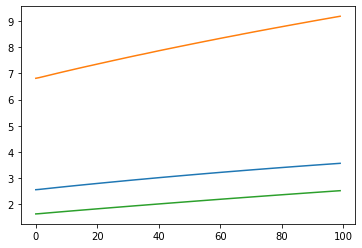

In [126]:
plt.plot(resultsarray[2])
plt.plot(resultsarray_land[2])
plt.plot(resultsarray_ocean[2])

(0.0, 10.0)

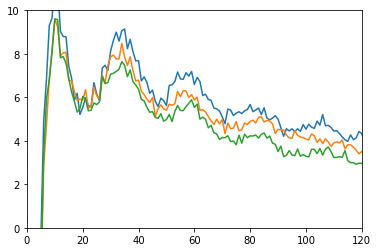

In [119]:
plt.plot(lwavgarray[1]+swavgarray[1])
plt.plot(lwavgarray[2]+swavgarray[2])
plt.plot(lwavgarray[3]+swavgarray[3])
plt.xlim(0,120)
plt.ylim(0,10)

In [98]:
stddevlw = np.nanstd(lwavgarray,axis=0)
stddevsw = np.nanstd(swavgarray,axis=0)
stddevnet = np.sqrt(stddevlw**2 + stddevsw**2)

(-20.0, 20.0)

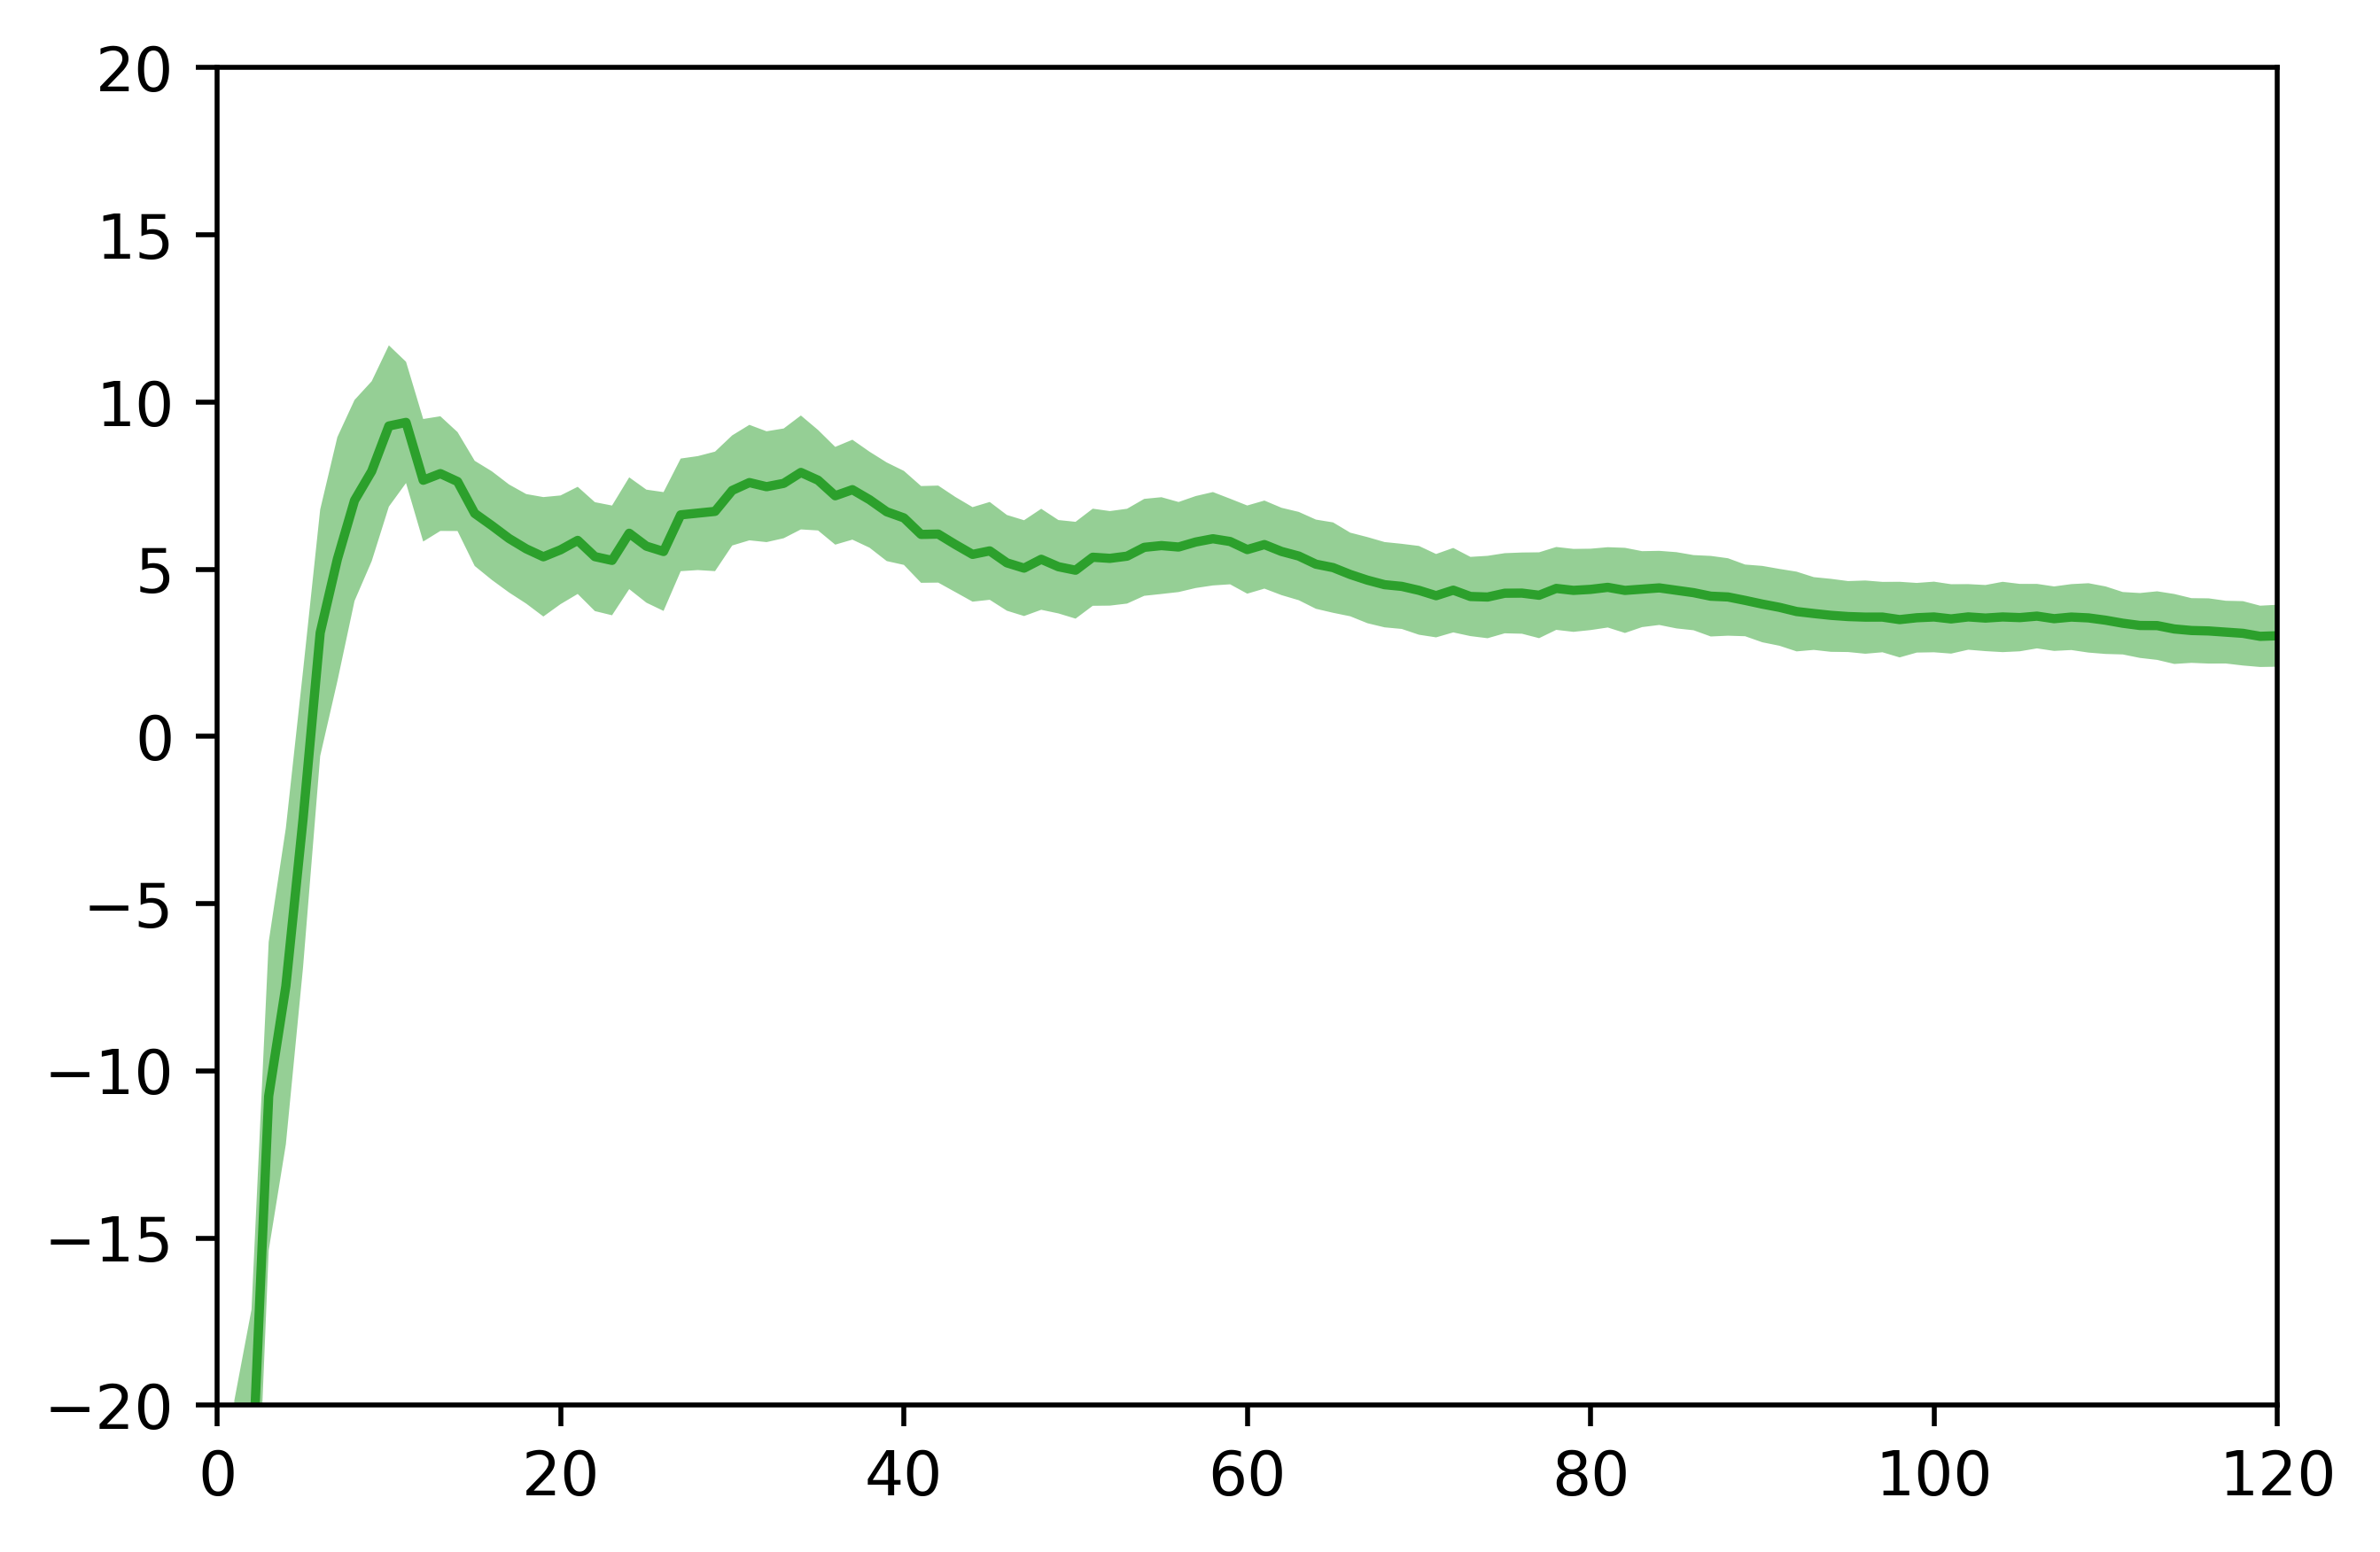

In [104]:
plt.figure(dpi=500)
plt.plot(np.nanmean(lwavgarray,axis=0))
plt.fill_between(np.arange(0,499,1),np.nanmean(lwavgarray,axis=0)-stddevlw,np.nanmean(lwavgarray,axis=0)+stddevlw,alpha=0.5)
plt.plot(np.nanmean(swavgarray,axis=0))
plt.fill_between(np.arange(0,499,1),np.nanmean(swavgarray,axis=0)-np.nanstd(swavgarray,axis=0),np.nanmean(swavgarray,axis=0)+np.nanstd(swavgarray,axis=0),alpha=0.5)
plt.plot(np.nanmean(lwavgarray,axis=0)+np.nanmean(swavgarray,axis=0))
plt.fill_between(np.arange(0,499,1),np.nanmean(lwavgarray,axis=0)+np.nanmean(swavgarray,axis=0)-stddevnet,np.nanmean(lwavgarray,axis=0)+np.nanmean(swavgarray,axis=0)+stddevnet,alpha=0.5)
plt.xlim(0,120)
plt.ylim(-20,20)

In [183]:
resultsnormed = np.zeros((17,100))
resultsnormed_land = np.zeros((17,100))
resultsnormed_ocean = np.zeros((17,100))
for i in range(17):
    resultsnormed[i] = resultsarray[i] - resultsarray[i,0]
    resultsnormed_land[i] = resultsarray_land[i] - resultsarray_land[i,0]
    resultsnormed_ocean[i] = resultsarray_ocean[i] - resultsarray_ocean[i,0]


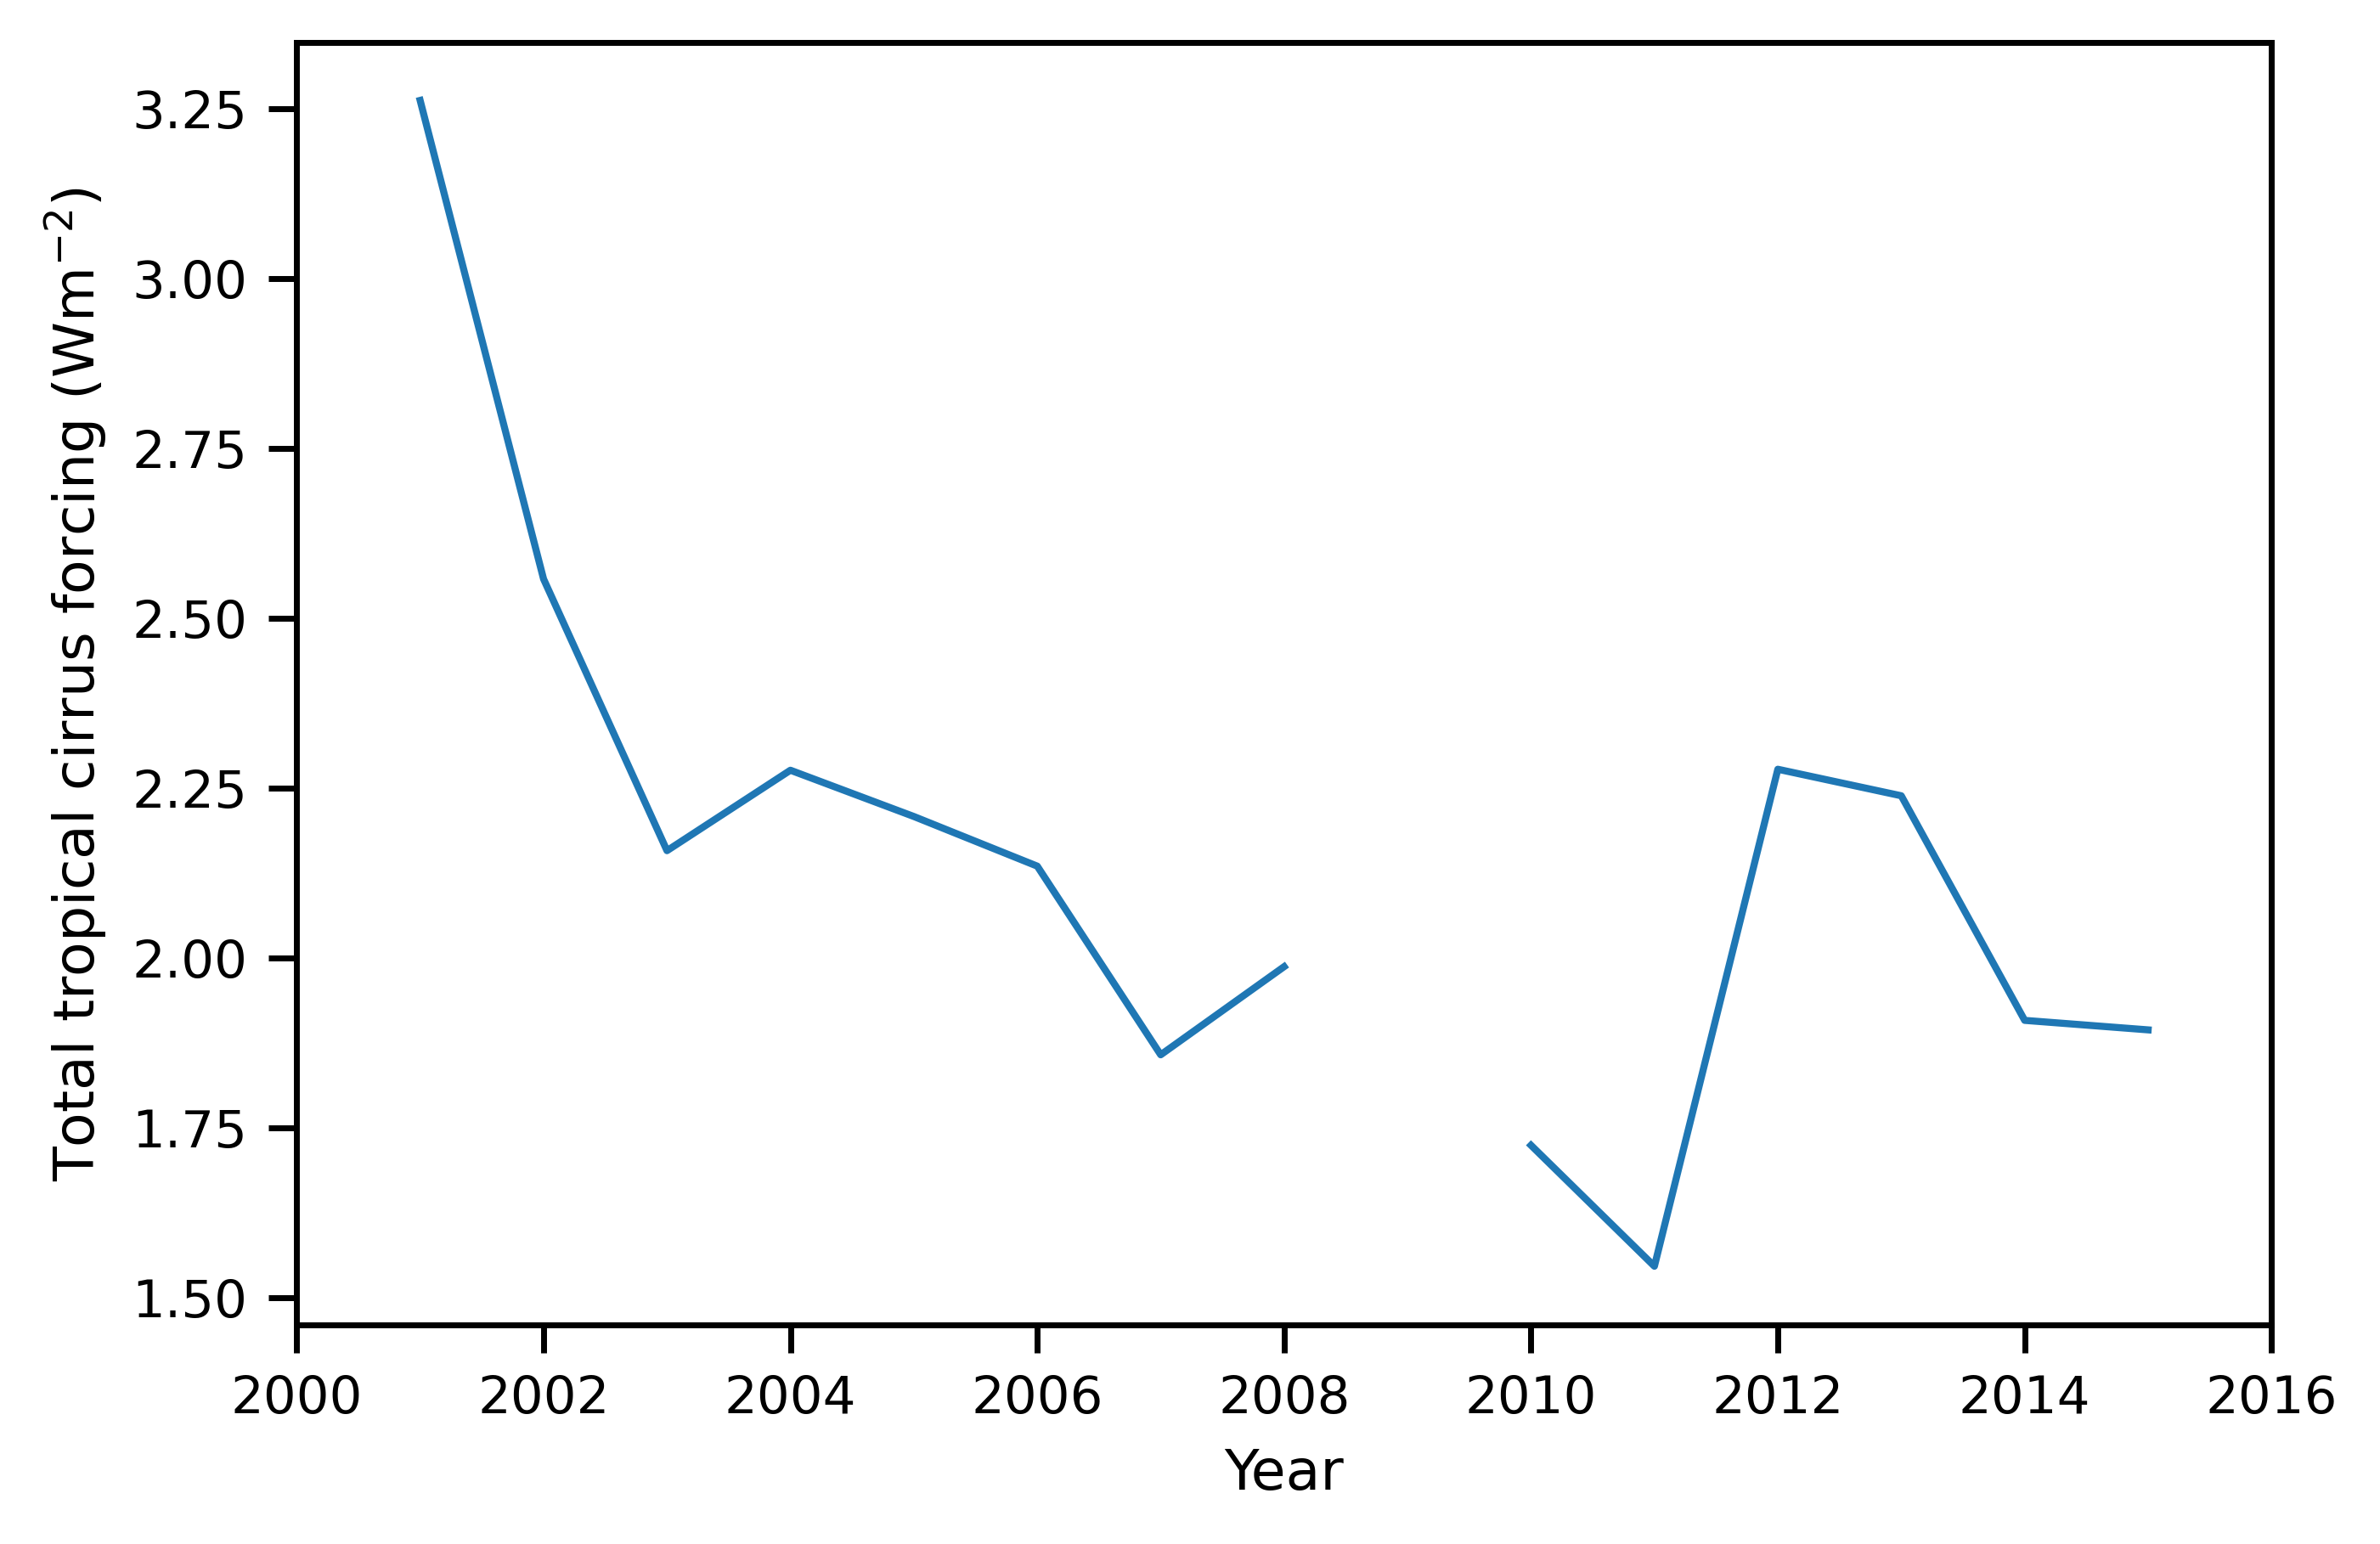

<Figure size 432x288 with 0 Axes>

In [227]:
plt.figure(dpi=500)
#plt.plot(resultsarray[:,0])

plt.plot(resultsarray[:,0])
plt.xlabel('Year')
plt.ylabel('Total tropical cirrus forcing (Wm$^{-2}$)')
plt.xticks(np.arange(0,17,2),np.arange(2000,2017,2))
plt.show()
plt.savefig('forcing_trend.png',dpi=500)

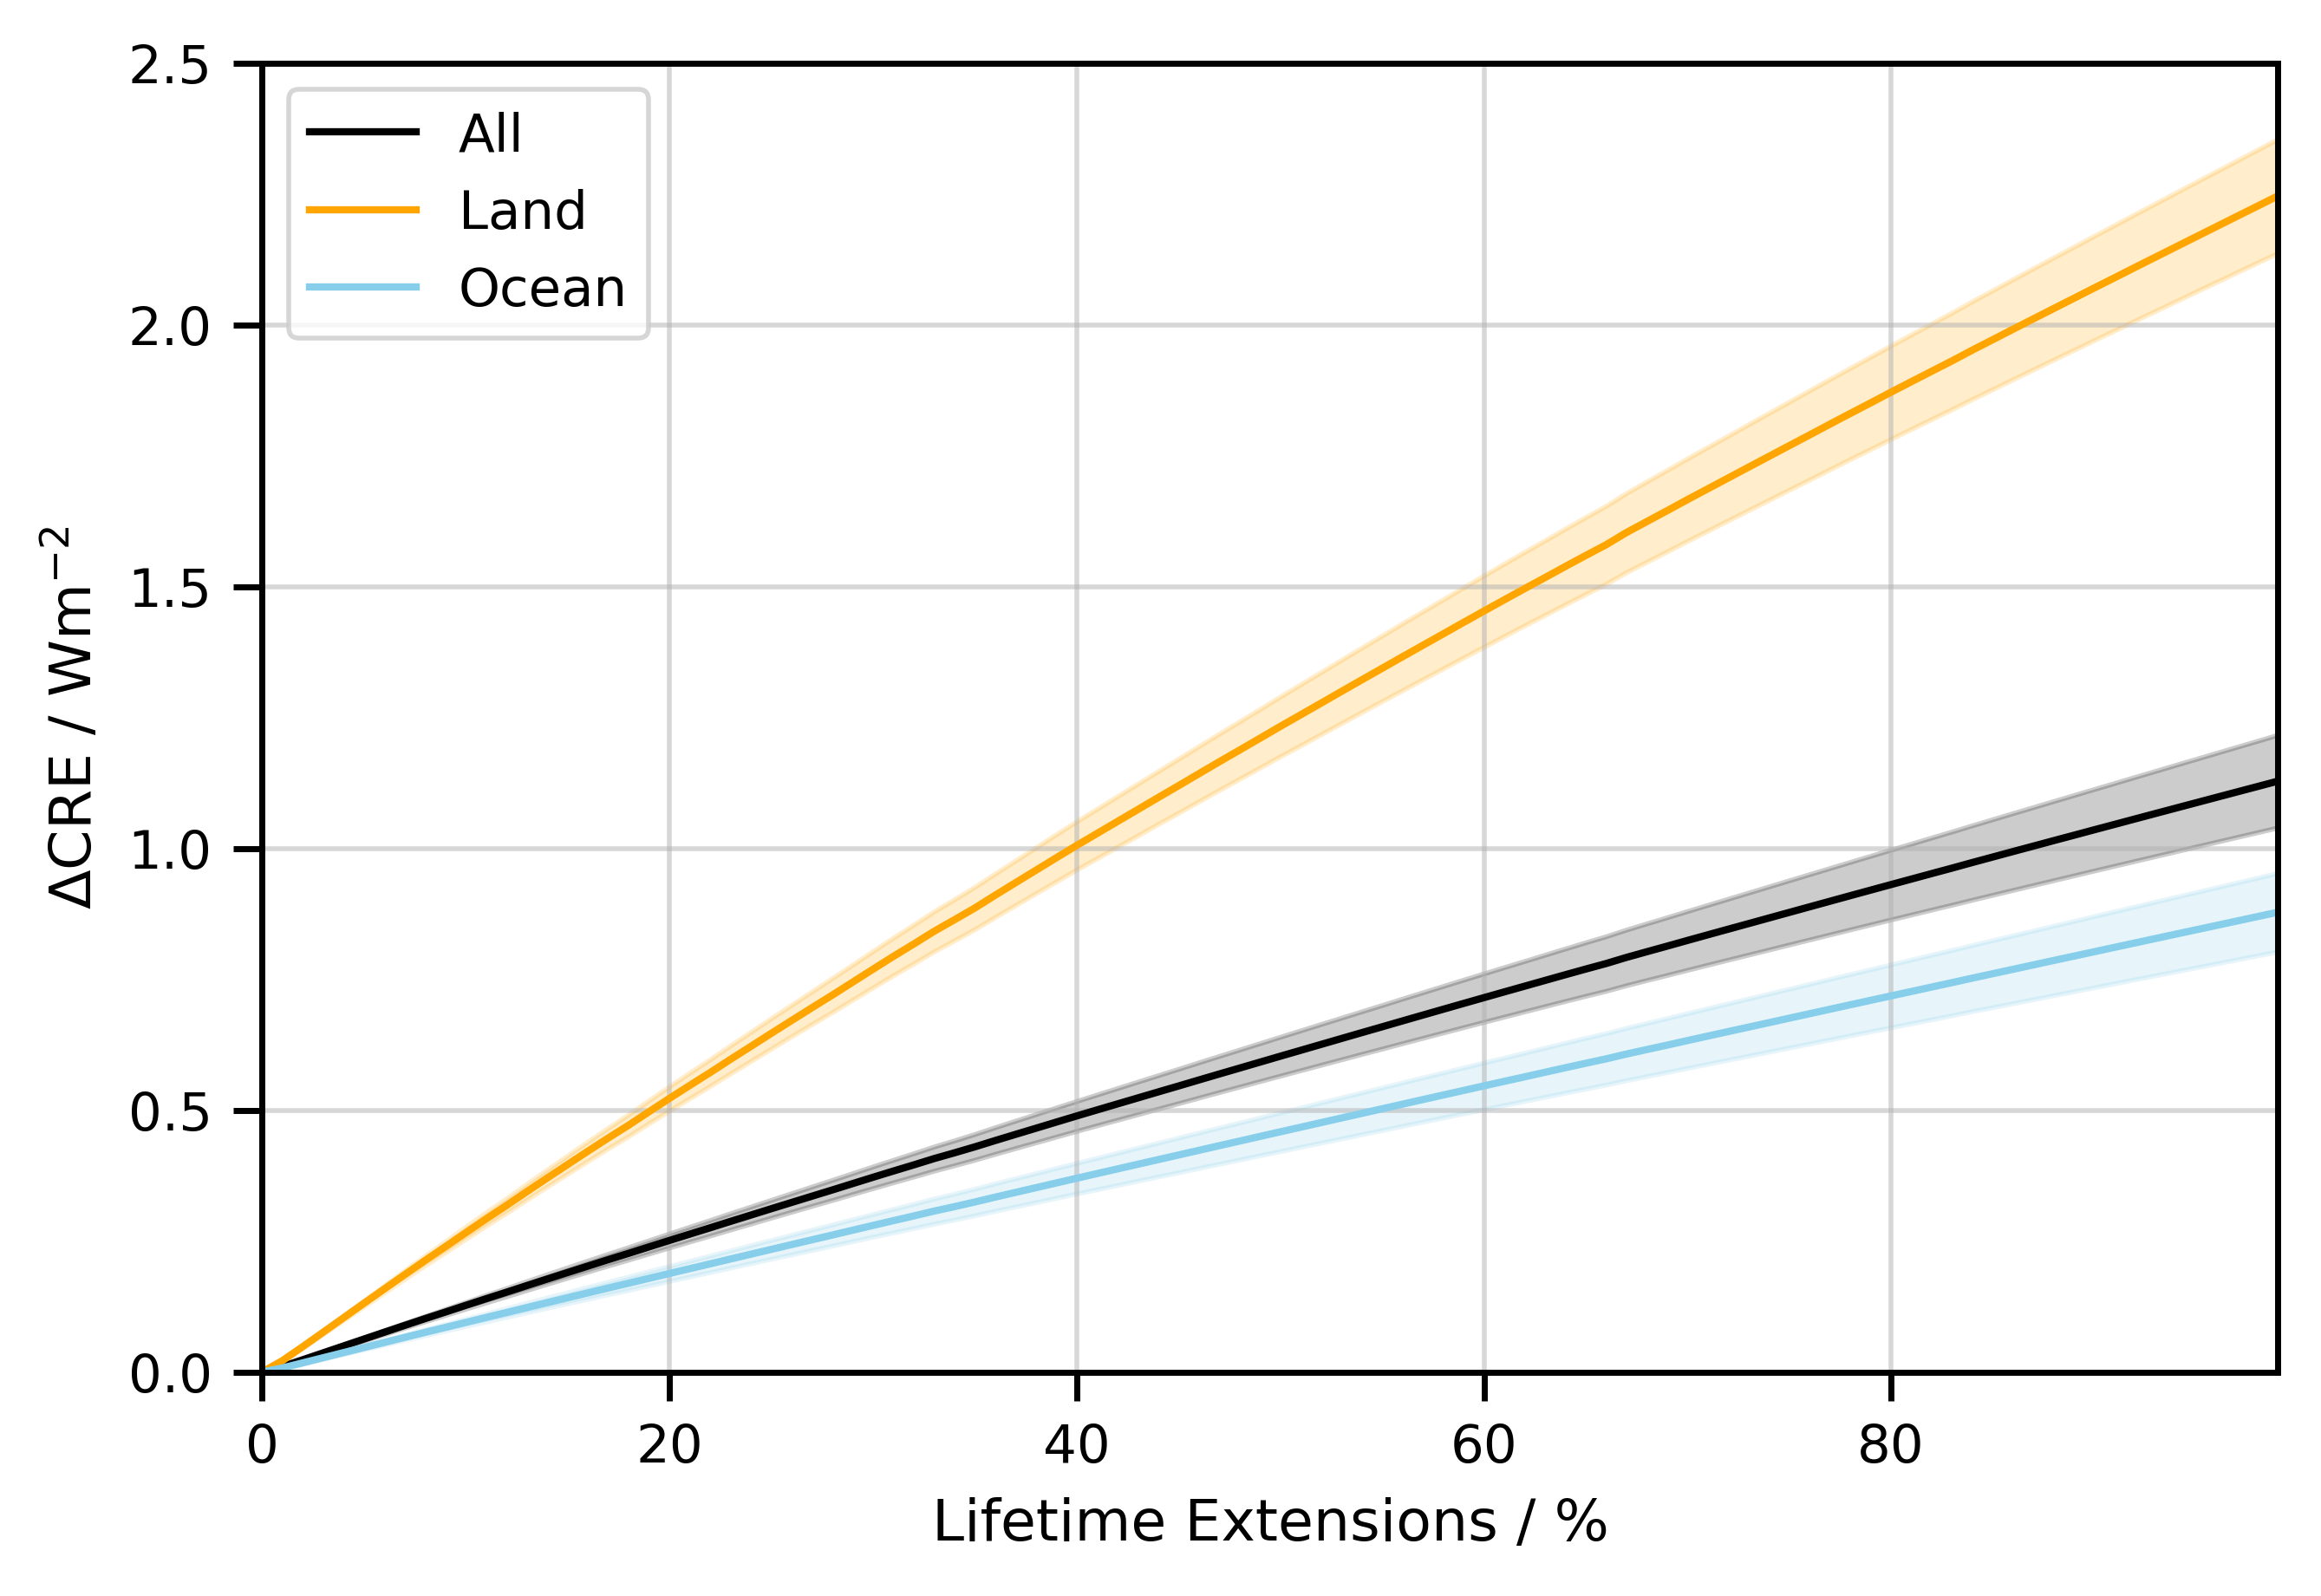

In [232]:
plt.figure(dpi=500)
plt.grid(alpha=0.5)
plt.plot(np.nanmean(resultsnormed,axis=0),color='k',label='All')
plt.fill_between(np.arange(0,100,1),np.nanmean(resultsnormed,axis=0)+np.nanstd(resultsnormed,axis=0),np.nanmean(resultsnormed,axis=0)-np.nanstd(resultsnormed,axis=0),alpha=0.2,color='k')
plt.plot(np.nanmean(resultsnormed_land,axis=0),color='orange',label='Land')
plt.fill_between(np.arange(0,100,1),np.nanmean(resultsnormed_land,axis=0)+np.nanstd(resultsnormed_land,axis=0),np.nanmean(resultsnormed_land,axis=0)-np.nanstd(resultsnormed_land,axis=0),alpha=0.2,color='orange')
plt.plot(np.nanmean(resultsnormed_ocean,axis=0),color='skyblue',label='Ocean')
plt.fill_between(np.arange(0,100,1),np.nanmean(resultsnormed_ocean,axis=0)+np.nanstd(resultsnormed_ocean,axis=0),np.nanmean(resultsnormed_ocean,axis=0)-np.nanstd(resultsnormed_ocean,axis=0),alpha=0.2,color='skyblue')
plt.xlim(0,99)
plt.ylim(0,2.5)
plt.xlabel('Lifetime Extensions / %')
plt.ylabel('$\Delta$CRE / Wm$^{-2}$')
plt.legend()
plt.savefig('CRE_lifetime.pdf',bbox_inches='tight',dpi=1200)

(0.0, 100.0)

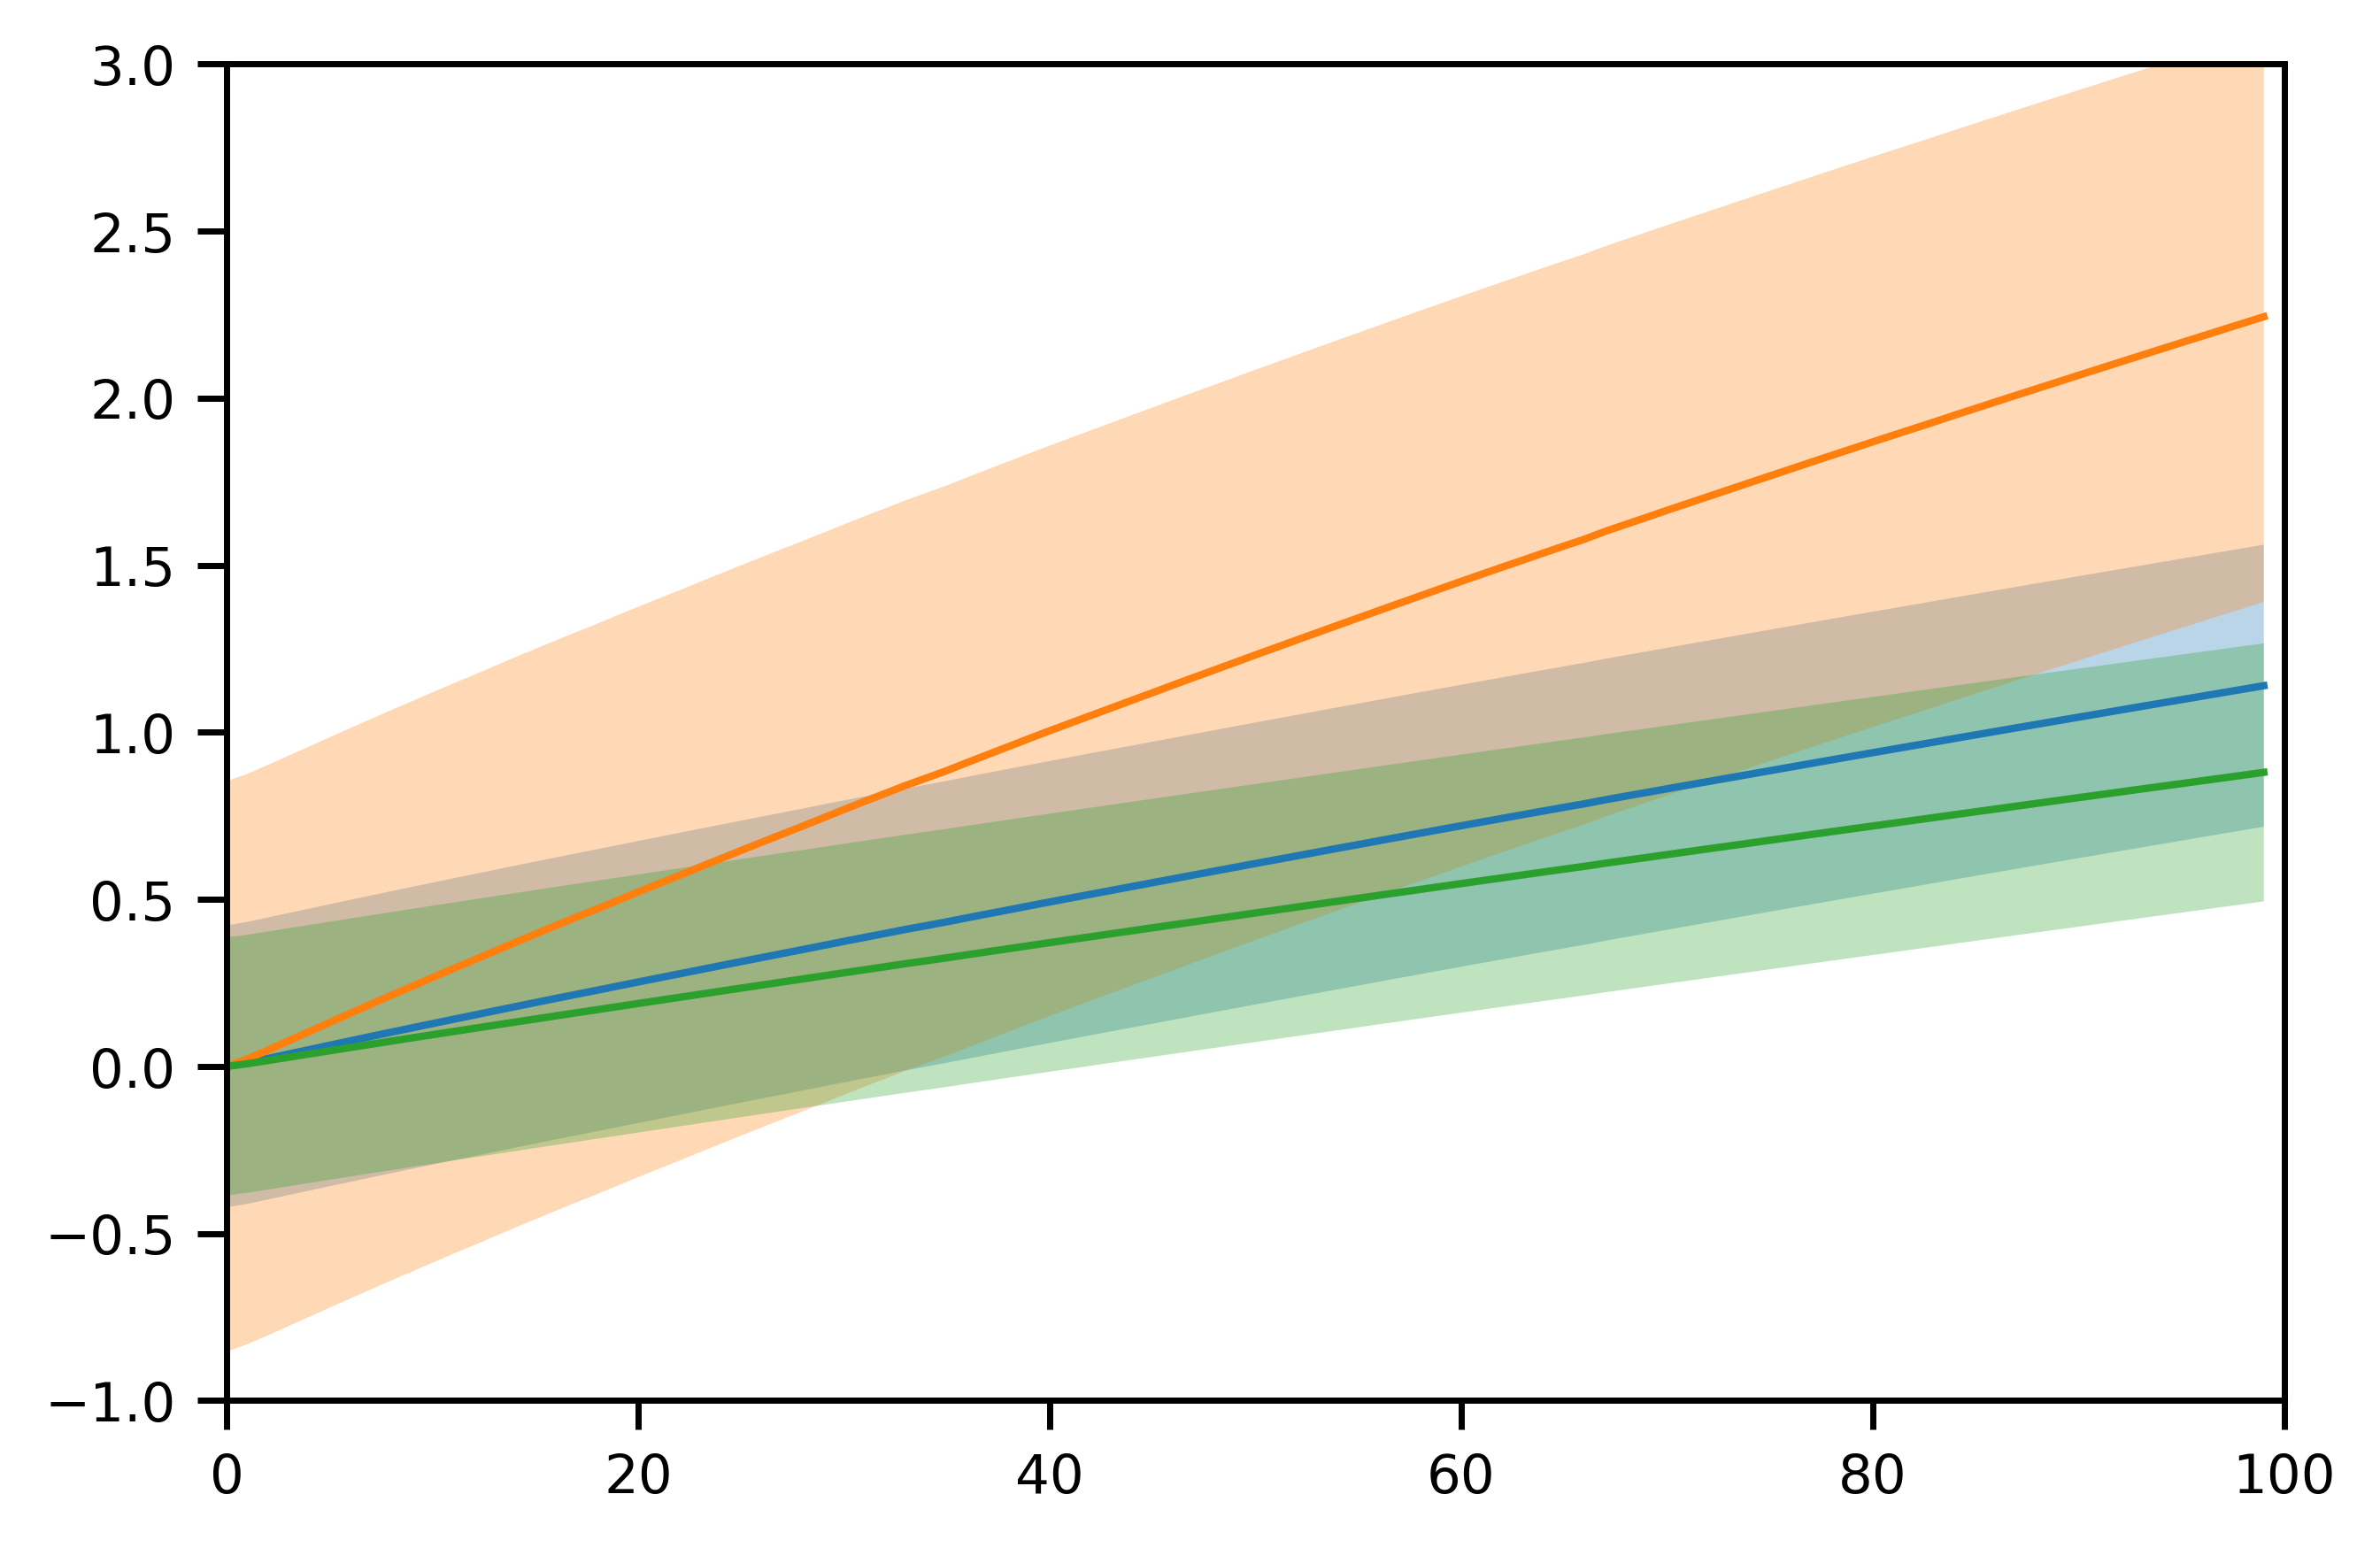

In [155]:
import seaborn as sns
sns.set_context('paper')
plt.figure(dpi=500)
plt.plot(resultsnormed)
plt.fill_between(np.arange(0,100,1),resultsnormed-np.nanstd(resultsarray[2:]),resultsnormed+np.nanstd(resultsarray[2:]),alpha=0.3)
plt.plot(resultsnormed_land)
plt.fill_between(np.arange(0,100,1),resultsnormed_land-np.nanstd(resultsarray_land[2:]),resultsnormed_land+np.nanstd(resultsarray_land[2:]),alpha=0.3)
plt.plot(resultsnormed_ocean)
plt.fill_between(np.arange(0,100,1),resultsnormed_ocean-np.nanstd(resultsarray_ocean[2:]),resultsnormed_ocean+np.nanstd(resultsarray_ocean[2:]),alpha=0.3)
plt.ylim(-1,3)
plt.xlim(0,100)

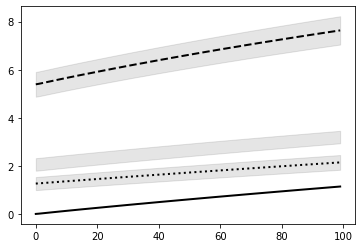

In [132]:
plt.plot(np.nanmean(resultsarray[2:],axis=0)-np.nanmean(resultsarray[2:,0],axis=0),color='black',linewidth=2)
plt.fill_between(np.arange(100),np.nanmean(resultsarray[2:],axis=0)+np.nanstd(resultsarray[2:],axis=0),np.nanmean(resultsarray[2:],axis=0)-np.nanstd(resultsarray[2:],axis=0),color='black',alpha=0.1)
plt.plot(np.nanmean(resultsarray_land[2:],axis=0),color='black',linewidth=2,linestyle='dashed')
plt.fill_between(np.arange(100),np.nanmean(resultsarray_land[2:],axis=0)+np.nanstd(resultsarray_land[2:],axis=0),np.nanmean(resultsarray_land[2:],axis=0)-np.nanstd(resultsarray_land[2:],axis=0),color='black',alpha=0.1)
plt.plot(np.nanmean(resultsarray_ocean[2:],axis=0),color='black',linewidth=2,linestyle='dotted')
plt.fill_between(np.arange(100),np.nanmean(resultsarray_ocean[2:],axis=0)+np.nanstd(resultsarray_ocean[2:],axis=0),np.nanmean(resultsarray_ocean[2:],axis=0)-np.nanstd(resultsarray_ocean[2:],axis=0),color='black',alpha=0.1)

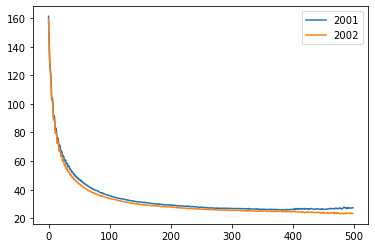

In [ ]:

plt.plot(lwavg[1],label='2001')
plt.plot(lwavg[2],label='2002')
plt.legend()

In [23]:
resutlslistvect = np.vectorize(resultslist[0])

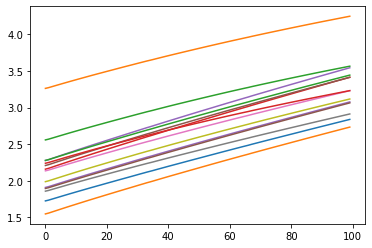

In [7]:
plt.plot(resultslist[0])
plt.plot(resultslist[1])
plt.plot(resultslist[2])
plt.plot(resultslist[3])
plt.plot(resultslist[4])
plt.plot(resultslist[5])
plt.plot(resultslist[6])
plt.plot(resultslist[7])
plt.plot(resultslist[8])
plt.plot(resultslist[9])
plt.plot(resultslist[10])
plt.plot(resultslist[11])
plt.plot(resultslist[12])
plt.plot(resultslist[13])
plt.plot(resultslist[14])
plt.plot(resultslist[15])

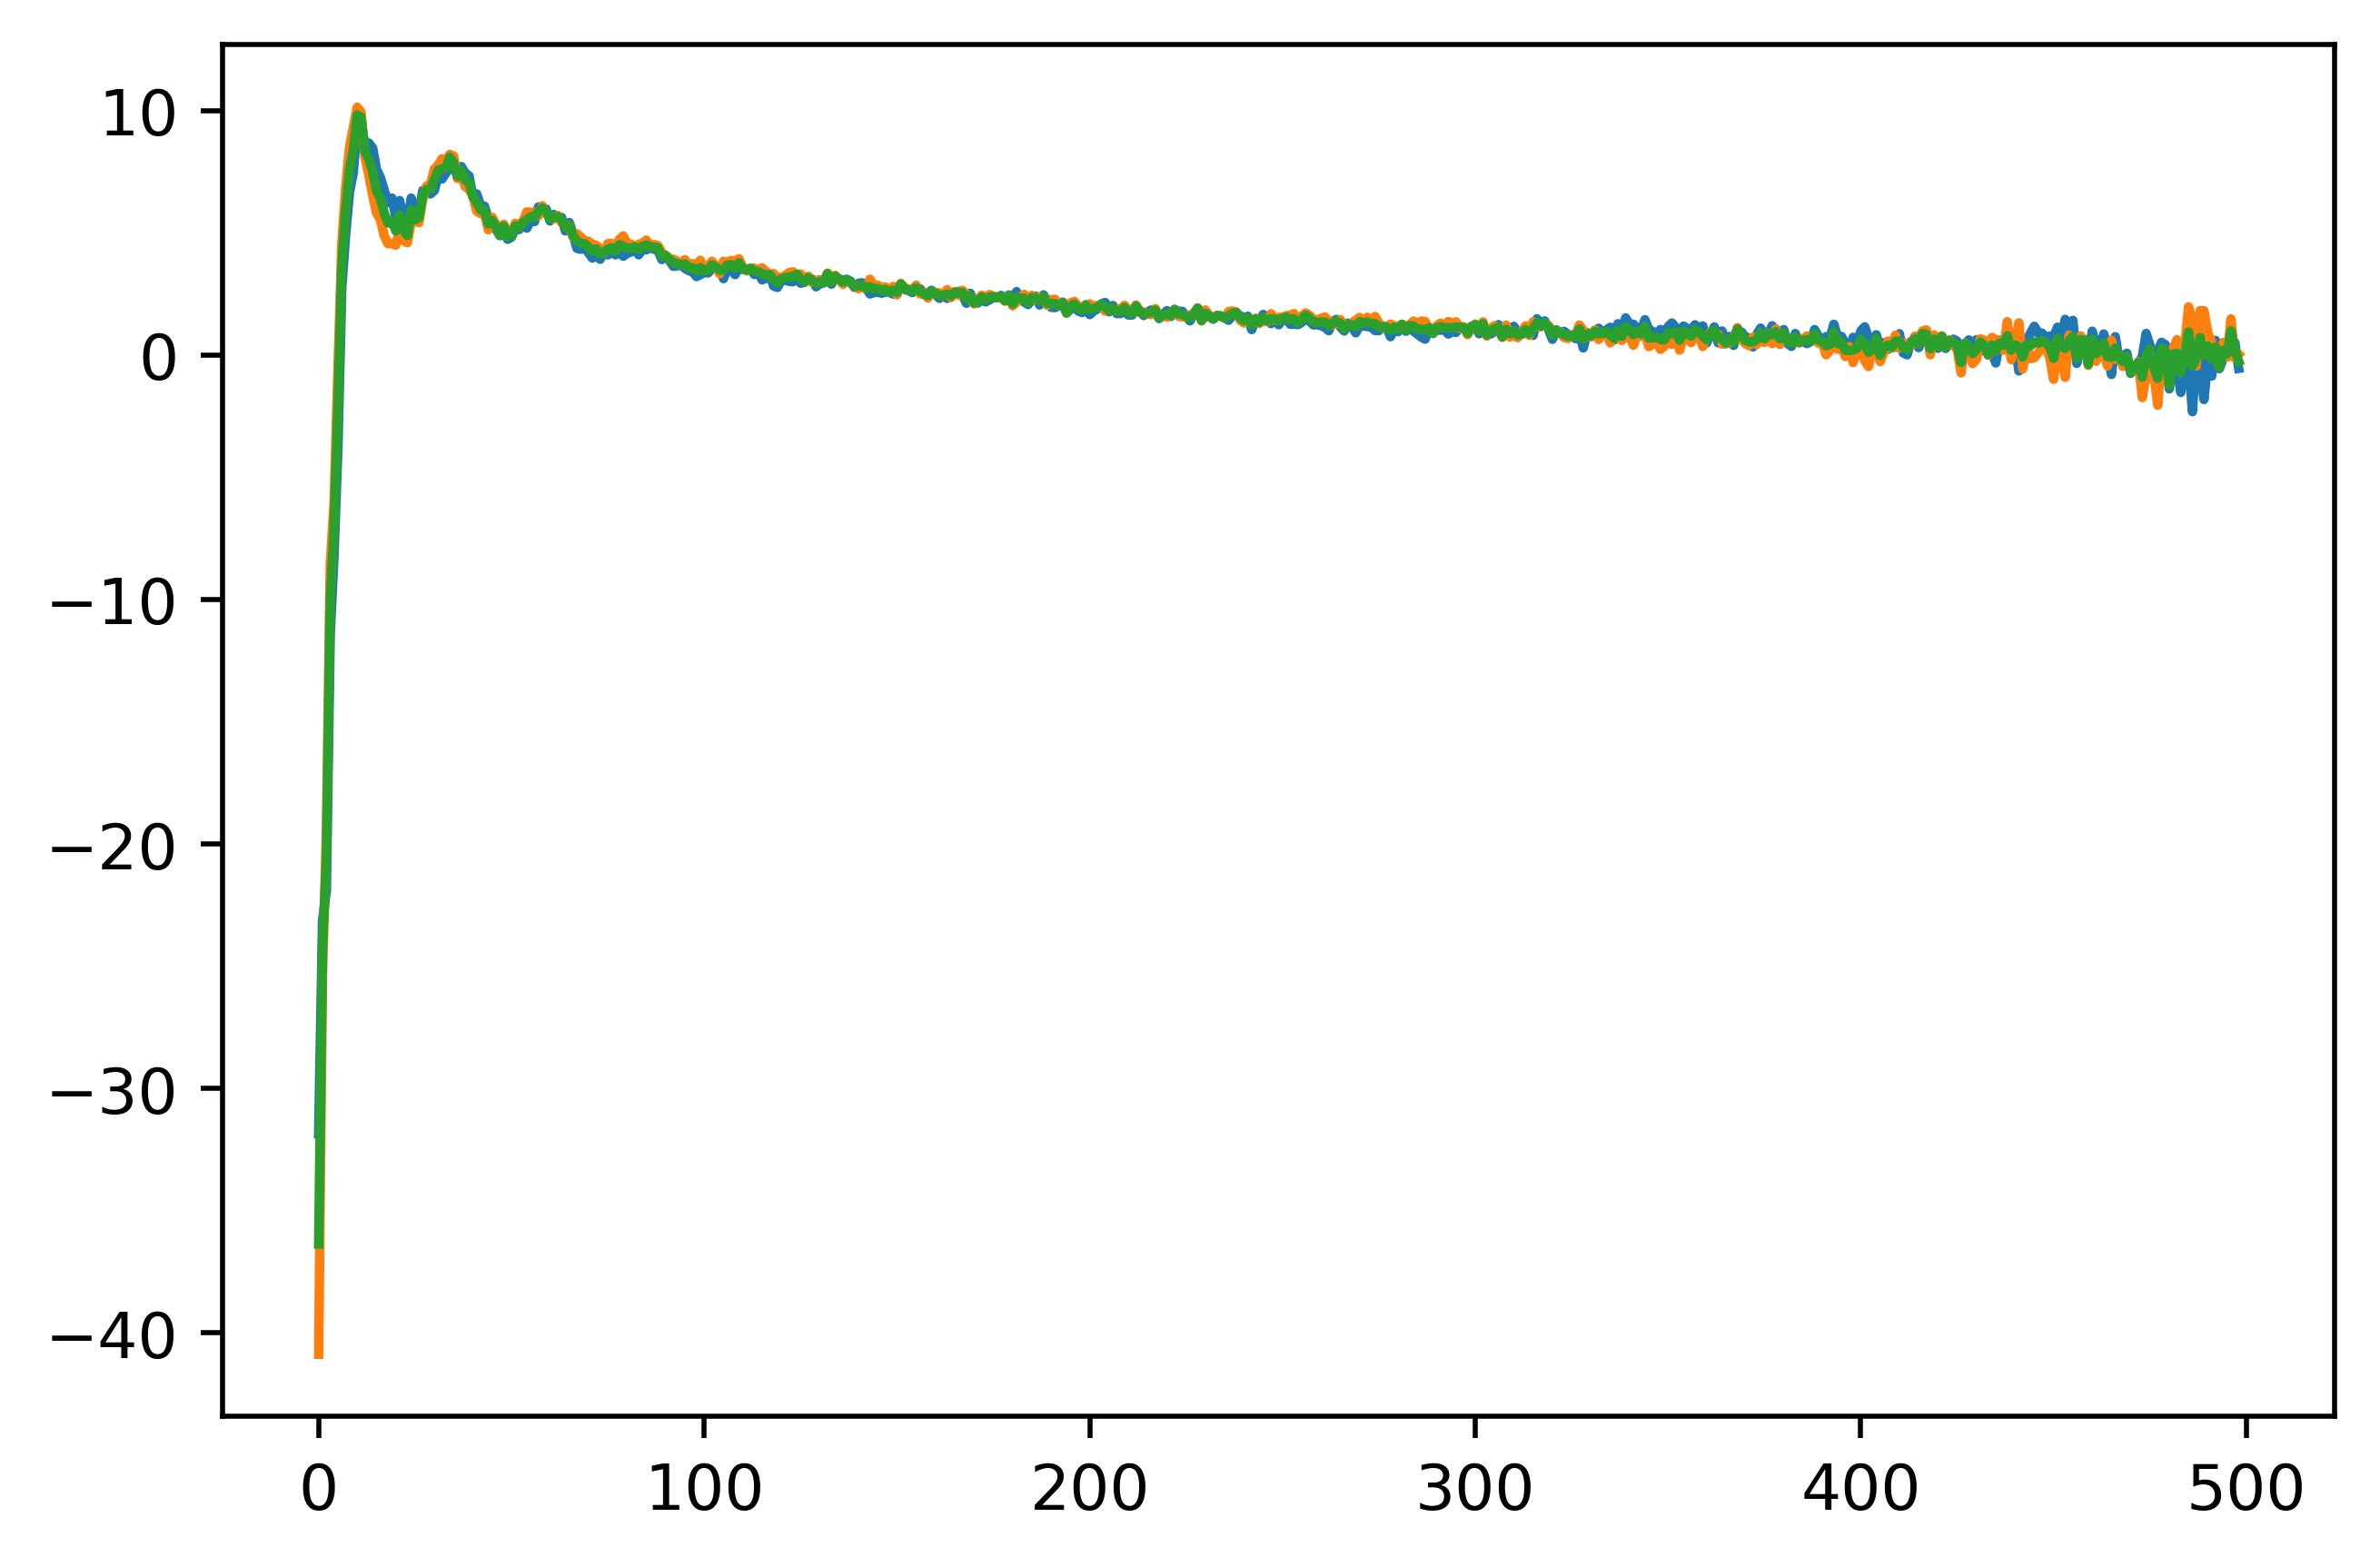

In [ ]:
plt.figure(dpi=500)
plt.plot(np.asarray(pmap)[0])
plt.plot(np.asarray(pmap)[1])
plt.plot(np.nanmean(np.asarray(pmap)[:],axis=0))

TypeError: 'vectorize' object is not subscriptable

(-10.0, 20.0)

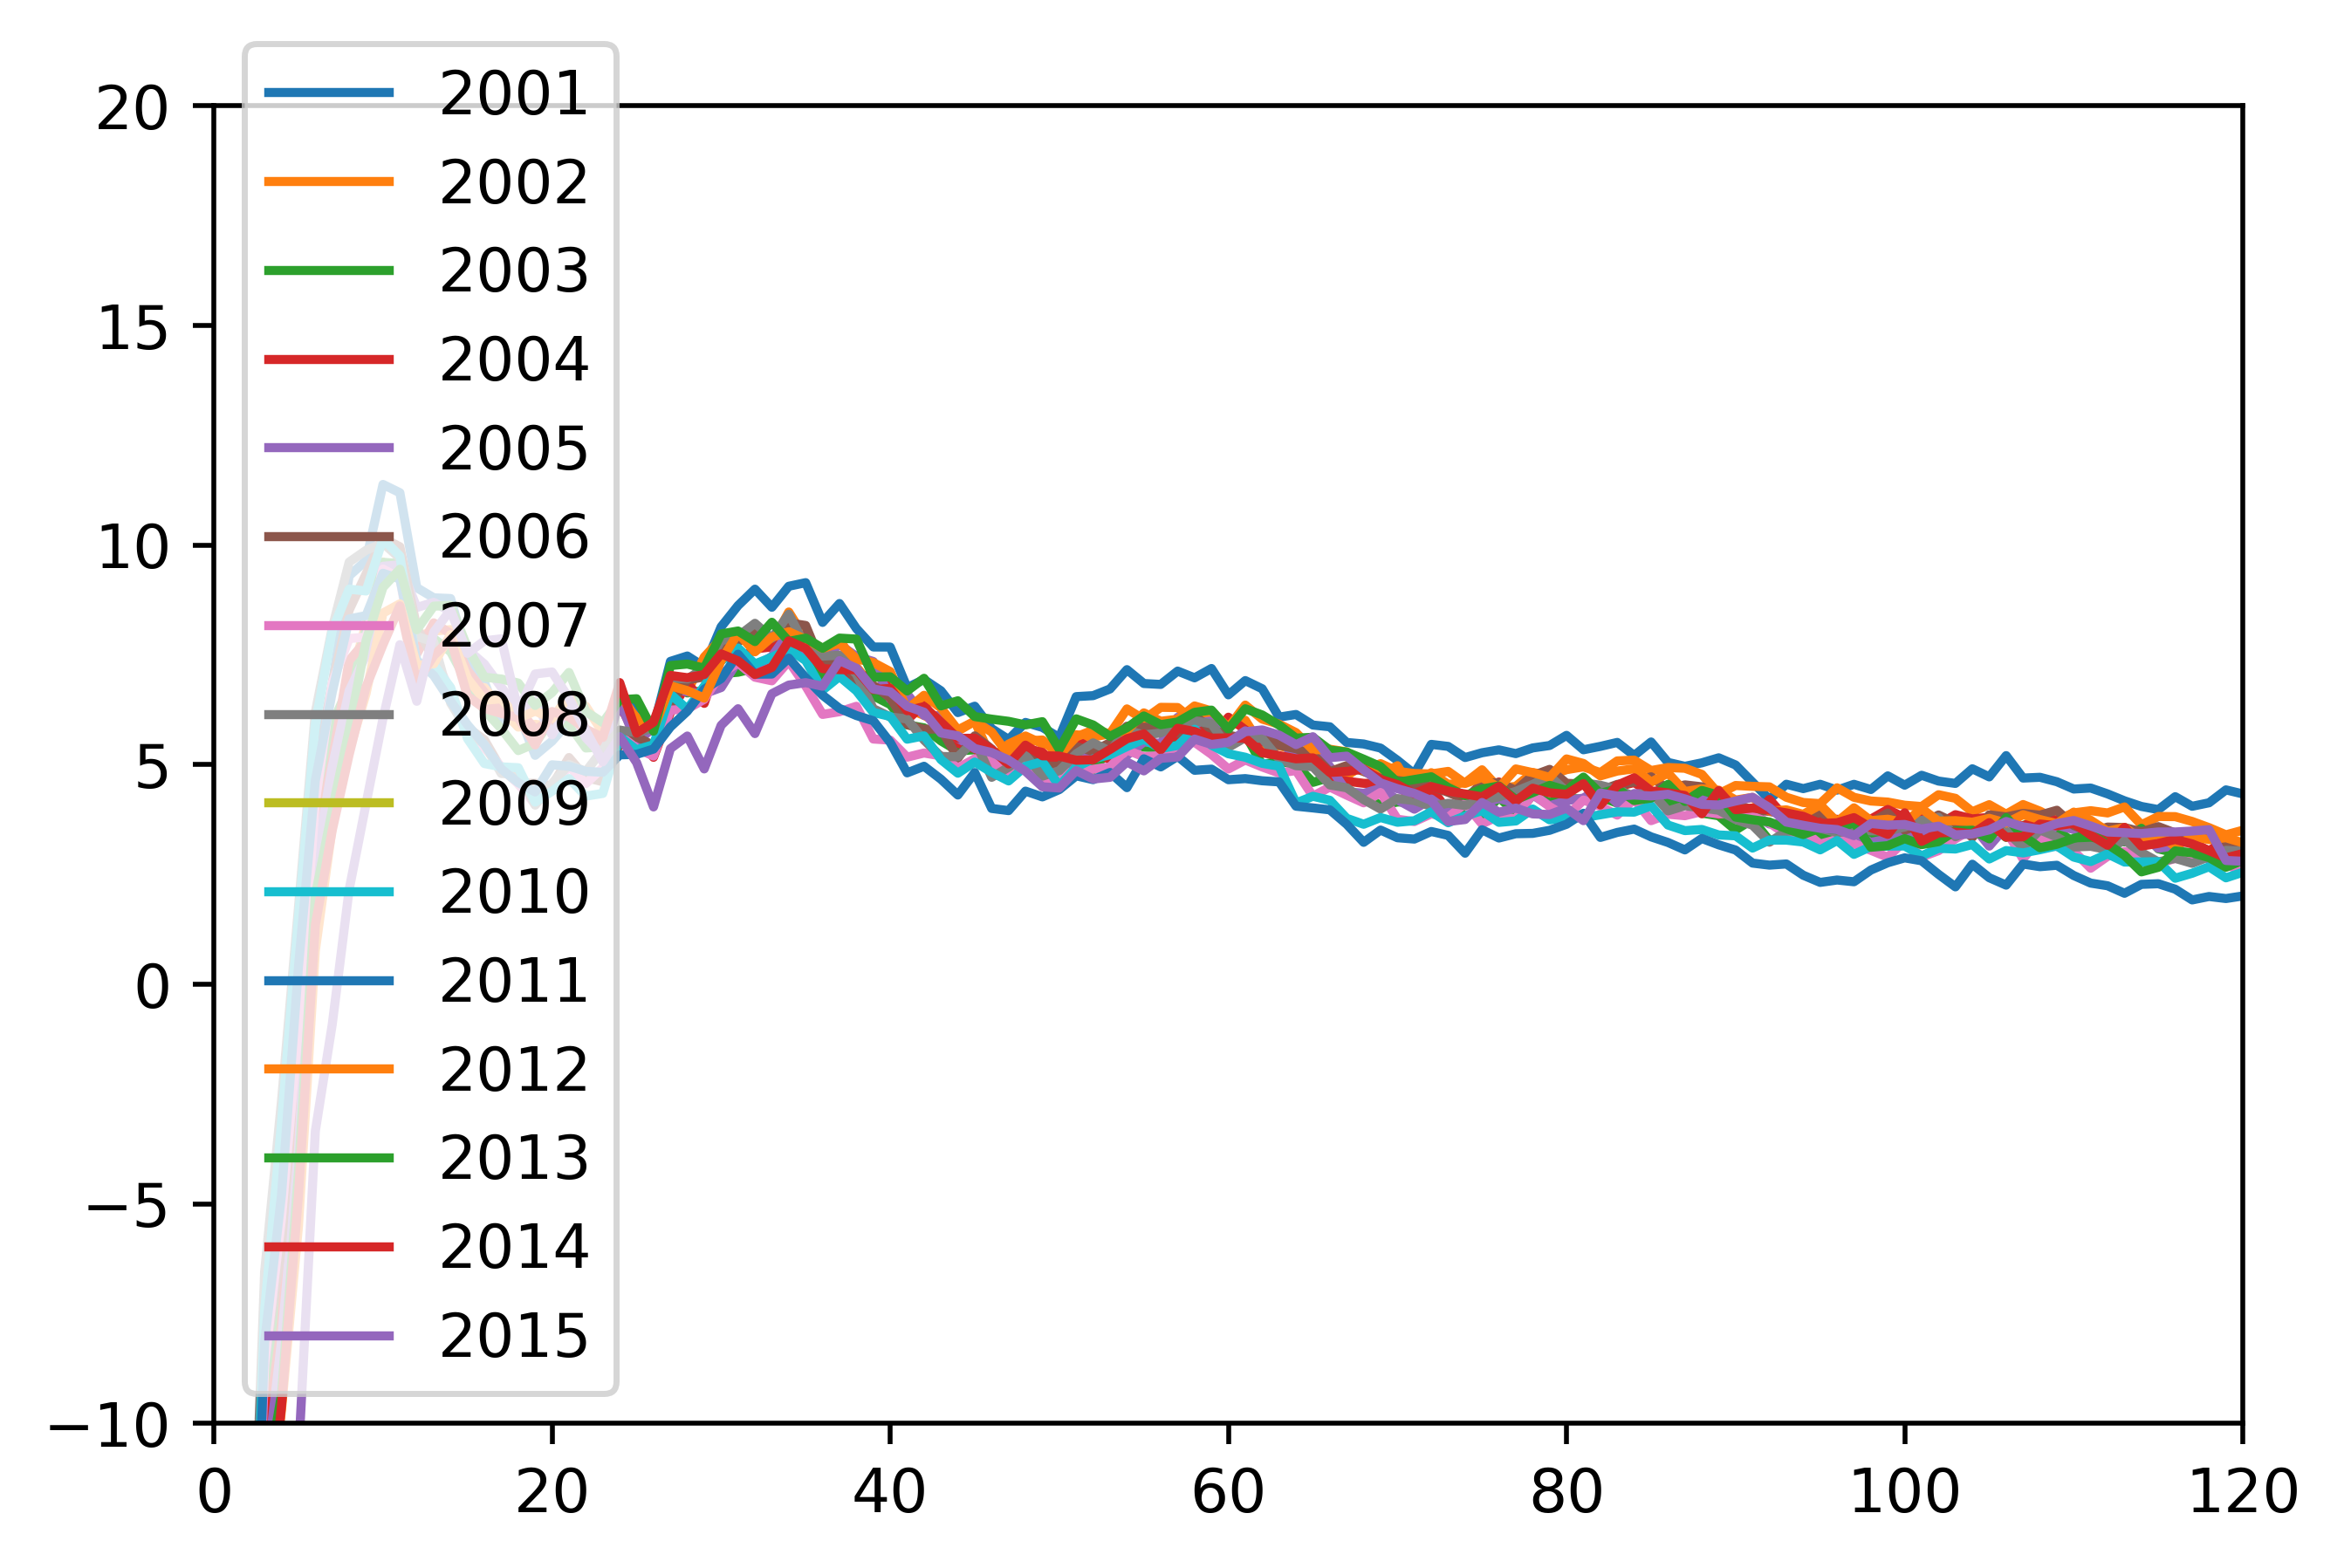

In [ ]:
plt.figure(dpi=500)
plt.plot(np.nanmean(pmap[:][0] + pmap),label='2001')
plt.plot(pmap[0][1] + pmap[0][2],label='2001')
plt.plot(pmap[1][1] + pmap[1][2],label='2002')
plt.plot(pmap[2][1] + pmap[2][2],label='2003')
plt.plot(pmap[3][1] + pmap[3][2],label='2004')
plt.plot(pmap[4][1] + pmap[4][2],label='2005')
plt.plot(pmap[5][1] + pmap[5][2],label='2006')
plt.plot(pmap[6][1] + pmap[6][2],label='2007')
plt.plot(pmap[7][1] + pmap[7][2],label='2008')
plt.plot(pmap[8][1] + pmap[8][2],label='2009')
plt.plot(pmap[9][1] + pmap[9][2],label='2010')
plt.plot(pmap[10][1] + pmap[10][2],label='2011')
plt.plot(pmap[11][1] + pmap[11][2],label='2012')
plt.plot(pmap[12][1] + pmap[12][2],label='2013')
plt.plot(pmap[13][1] + pmap[13][2],label='2014')
plt.plot(pmap[14][1] + pmap[14][2],label='2015')

plt.xlim(0,120)
plt.legend()
plt.ylim
plt.ylim(-10,20)

In [ ]:
pmap[3][0]

2.2789330835371615

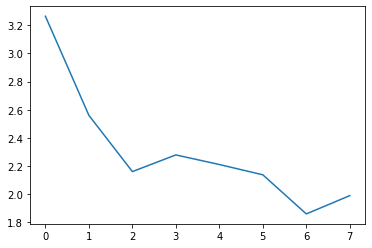

In [ ]:
plt.plot([pmap[0][0],pmap[1][0],pmap[2][0],pmap[3][0],pmap[4][0],pmap[5][0],pmap[6][0],pmap[7][0]])

In [ ]:
isccptime[:]

<xarray.DataArray 'time' (time: 2919)>
array(['2009-01-01T00:00:00.000000000', '2009-01-01T03:00:00.000000000',
       '2009-01-01T06:00:00.000000000', ..., '2009-12-31T15:00:00.000000000',
       '2009-12-31T18:00:00.000000000', '2009-12-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-01-01 ... 2009-12-31T21:00:00
Attributes:
    long_name:     Time
    bounds:        time_bounds
    cell_methods:  time: mean

In [ ]:
import warnings
print('is it doing?')
timelen=499
yedges_net = np.arange(-650,650,1)
yedges_lw = np.arange(-500,0,1)
yedges_sw = np.arange(-100,900,1)
yedges_solar = np.arange(0,1400,5)
xedges = np.arange(0,timelen+1,1)
year=2009

tsc = xr.open_mfdataset('/disk1/Users/gah20/TSCnew/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['TSC'][:,2:62]
landocean = xr.open_mfdataset('/disk1/Users/gah20/TSCnew/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvOrigin'][:,2:62]
detinsit = xr.open_mfdataset('/disk1/Users/gah20/TSCnew/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvCir'][:,2:62]

isccp = xr.open_mfdataset('/disk1/Data/ISCCP/access/isccp-basic/hgg/'+str(year)+'*/20*.nc',combine='nested',concat_dim='time')
taupc = isccp['n_pctaudist']
levtau = isccp['levtau']
levpc = isccp['levpc']
tauraw = isccp['tau']
pcraw = isccp['pc']
isccptime = isccp['time']

ds_w = xr.open_mfdataset('/disk1/Data/CERES/CERES_year'+str(year)+'.nc')
swall = ds_w['toa_sw_all_1h'][:,60:120]
swclr = ds_w['toa_sw_clr_1h'][:,60:120]
lwall = ds_w['toa_lw_all_1h'][:,60:120]
lwclr = ds_w['toa_lw_clr_1h'][:,60:120]

ds_alb = xr.open_mfdataset('/disk1/Data/CERES/2024_dwld/CERES_year'+str(year)+'.nc')
solar = ds_alb['toa_solar_all_1h'][:,60:120]
alb_all = ds_alb['toa_alb_all_1h'][:,60:120]
alb_clr = ds_alb['toa_alb_clr_1h'][:,60:120]
timeceres = ds_alb['time'][:]
#cf = ds_alb['cldarea_total_1h'][:]
print('all dated loaded in')

print(len(isccp['time'][offset:]))
print(len(tsc[offset*3:])/3)
print(len(swall)/3)

is it doing?
all dated loaded in
2919
2920.0
2920.0


In [ ]:

import warnings
print('is it doing?')
timelen=499
yedges_net = np.arange(-650,650,1)
yedges_lw = np.arange(-500,0,1)
yedges_sw = np.arange(-100,900,1)
yedges_solar = np.arange(0,1400,5)
xedges = np.arange(0,timelen+1,1)
year=2005

tsc = xr.open_mfdataset('/disk1/Users/gah20/TSCnew/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['TSC'][:,2:62]
landocean = xr.open_mfdataset('/disk1/Users/gah20/TSCnew/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvOrigin'][:,2:62]
detinsit = xr.open_mfdataset('/disk1/Users/gah20/TSCnew/'+str(year)+'/TSC*.nc',combine='nested',concat_dim='time')['ConvCir'][:,2:62]

isccp = xr.open_mfdataset('/disk1/Data/ISCCP/access/isccp-basic/hgg/'+str(year)+'*/20*.nc',combine='nested',concat_dim='time')
taupc = isccp['n_pctaudist']
levtau = isccp['levtau']
levpc = isccp['levpc']
tauraw = isccp['tau']
pcraw = isccp['pc']
isccptime = isccp['time']

ds_w = xr.open_mfdataset('/disk1/Data/CERES/CERES_year'+str(year)+'.nc')
swall = ds_w['toa_sw_all_1h'][:,60:120]
swclr = ds_w['toa_sw_clr_1h'][:,60:120]
lwall = ds_w['toa_lw_all_1h'][:,60:120]
lwclr = ds_w['toa_lw_clr_1h'][:,60:120]

ds_alb = xr.open_mfdataset('/disk1/Data/CERES/2024_dwld/CERES_year'+str(year)+'.nc')
solar = ds_alb['toa_solar_all_1h'][:,60:120]
alb_all = ds_alb['toa_alb_all_1h'][:,60:120]
alb_clr = ds_alb['toa_alb_clr_1h'][:,60:120]
timeceres = ds_alb['time'][:]
#cf = ds_alb['cldarea_total_1h'][:]
print('all dated loaded in')
offset = np.argmin(np.abs(isccp['time'][:].values - ds_w['time'][0].values))

if (len(isccp['time'][offset:])) == (len(tsc[offset*3:])/3):
    
    swcldycalc = -(swall[0::3][0:len(isccp['time'][offset:])] - swclr[0::3][0:len(isccp['time'][offset:])])

    meanlw = np.nanmean(lwclr[:],axis=0)
    levels = 4
    lowcldamt = 1

    lowcloudraw = np.nansum(isccp['n_pcdist'][offset:,:levels,60:120],axis=1)
    lowcloud_day = np.where(lowcloudraw<0,np.nan,lowcloudraw)

    solar_t = solar[0::3][0:len(isccp['time'][offset:])]
    alb_all_t = alb_all[0::3][0:len(isccp['time'][offset:])]
    alb_clr_t = alb_clr[0::3][0:len(isccp['time'][offset:])]

    alb_all_t_sm = np.where(solar_t<700,np.nan,alb_all_t) 
    alb_clr_t_sm = np.where(solar_t<700,np.nan,alb_clr_t)
    solar_t_sm = np.where(solar_t<700,np.nan,solar_t)

    low_alb = np.where(lowcloud_day[:]<1,alb_all_t_sm - alb_clr_t_sm,np.nan)
    bkg_alb = np.where(lowcloud_day[:]<1,alb_all_t_sm,np.nan)

    alb_high_low = alb_all_t - (alb_clr_t + np.nanmean(low_alb,axis=0))
    alb_high_low = np.where(np.isnan(alb_high_low),0,alb_high_low)
    alb_high_bkg = alb_all_t - np.nanmean(bkg_alb,axis=0)
    alb_high_bkg = np.where(np.isnan(alb_high_bkg),0,alb_high_bkg)
    print('albedos done')
    lwclr_f = np.where(np.isnan(lwclr[0::3][0:len(isccp['time'][offset:])]),meanlw,lwclr[0::3][0:len(isccp['time'][offset:])])
    lwcldy = (lwall[0::3][0:len(isccp['time'][offset:])] - lwclr_f) 
    swcldy = solar_t*alb_high_low
    swcldy_bkg = solar_t*alb_high_bkg

    swcldyzerobkg = np.where(swcldy_bkg<0,0,swcldy_bkg)
    swcldyzeroall = np.where(swcldy<0,0,swcldy)

    tsc_t = (np.asarray(tsc[offset*3::3]))
    tsc_d = np.asarray(np.where(detinsit[offset*3::3]>=0,tsc[offset*3::3],np.nan))
    tsc_i = np.asarray(np.where(np.isnan(tsc_d),tsc[offset*3::3],np.nan))
    tsc_o = np.asarray(np.where(landocean[offset*3::3]<0,tsc[offset*3::3],np.nan))
    tsc_l = np.asarray(np.where(landocean[offset*3::3]>0,tsc[offset*3::3],np.nan))

    tsc_o_d = np.asarray(np.where(landocean[offset*3::3]<0,tsc_d,np.nan))
    tsc_o_i = np.asarray(np.where(landocean[offset*3::3]<0,tsc_i,np.nan))

    tsc_l_d = np.asarray(np.where(landocean[offset*3::3]>0,tsc_d,np.nan))
    tsc_l_i = np.asarray(np.where(landocean[offset*3::3]>0,tsc_i,np.nan))

    print('starting histograms')
    H_lw, xedges, yedges_lw = np.histogram2d(tsc_t.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw)) 
    H_sw, xedges, yedges_sw = np.histogram2d(tsc_t.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

    H_sw_det, xedges, yedges_sw = np.histogram2d(tsc_d.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))
    H_sw_ins, xedges, yedges_sw = np.histogram2d(tsc_i.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

    H_lw_det, xedges, yedges_lw = np.histogram2d(tsc_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
    H_lw_ins, xedges, yedges_lw = np.histogram2d(tsc_i.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

    H_lw_l, xedges, yedges_lw = np.histogram2d(tsc_l.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
    H_sw_l, xedges, yedges_sw = np.histogram2d(tsc_l.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

    H_lw_o, xedges, yedges_lw = np.histogram2d(tsc_o.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
    H_sw_o, xedges, yedges_sw = np.histogram2d(tsc_o.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

    H_lw_o_det, xedges, yedges_lw = np.histogram2d(tsc_o_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
    H_lw_o_ins, xedges, yedges_lw = np.histogram2d(tsc_o_i.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

    H_lw_l_det, xedges, yedges_lw = np.histogram2d(tsc_l_d.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))
    H_lw_l_ins, xedges, yedges_lw = np.histogram2d(tsc_l_i.flatten(),np.asarray(lwcldy).flatten(), bins=(xedges,yedges_lw))

    H_sw_o_det, xedges, yedges_sw = np.histogram2d(tsc_o_d.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))
    H_sw_o_ins, xedges, yedges_sw = np.histogram2d(tsc_o_i.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

    H_sw_l_det, xedges, yedges_sw = np.histogram2d(tsc_l_d.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))
    H_sw_l_ins, xedges, yedges_sw = np.histogram2d(tsc_l_i.flatten(),np.asarray(swcldyzerobkg).flatten(), bins=(xedges,yedges_sw))

    timelen=499

    H_norm_lw_all = np.zeros((timelen,499))
    H_norm_sw_all = np.zeros((timelen,999))

    H_norm_lw_o = np.zeros((timelen,499))
    H_norm_sw_o = np.zeros((timelen,999))

    H_norm_lw_l = np.zeros((timelen,499))
    H_norm_sw_l = np.zeros((timelen,999))

    H_norm_sw_det = np.zeros((timelen,999))
    H_norm_sw_ins = np.zeros((timelen,999))

    H_norm_lw_det = np.zeros((timelen,499))
    H_norm_lw_ins = np.zeros((timelen,499))

    H_norm_lw_o_det = np.zeros((timelen,499))
    H_norm_lw_o_ins = np.zeros((timelen,499))

    H_norm_lw_l_det = np.zeros((timelen,499))
    H_norm_lw_l_ins = np.zeros((timelen,499))

    H_norm_sw_o_det = np.zeros((timelen,999))
    H_norm_sw_o_ins = np.zeros((timelen,999))

    H_norm_sw_l_det = np.zeros((timelen,999))
    H_norm_sw_l_ins = np.zeros((timelen,999))



    for i in range(timelen):

        H_norm_lw_all[i] = H_lw[i] / np.sum(H_lw[i])
        H_norm_sw_all[i] = H_sw[i] / np.sum(H_sw[i])

        H_norm_lw_o[i] = H_lw_o[i] / np.sum(H_lw_o[i])
        H_norm_sw_o[i] = H_sw_o[i] / np.sum(H_sw_o[i])

        H_norm_lw_l[i] = H_lw_l[i] / np.sum(H_lw_l[i])
        H_norm_sw_l[i] = H_sw_l[i] / np.sum(H_sw_l[i])

        H_norm_sw_det[i] = H_sw_det[i] / np.sum(H_sw_det[i])
        H_norm_sw_ins[i] = H_sw_ins[i] / np.sum(H_sw_ins[i])

        H_norm_lw_det[i] = H_lw_det[i] / np.sum(H_lw_det[i])
        H_norm_lw_ins[i] = H_lw_ins[i] / np.sum(H_lw_ins[i])

        H_norm_lw_o_det[i] = H_lw_o_det[i] / np.sum(H_lw_o_det[i])
        H_norm_lw_o_ins[i] = H_lw_o_ins[i] / np.sum(H_lw_o_ins[i])

        H_norm_lw_l_det[i] = H_lw_l_det[i] / np.sum(H_lw_l_det[i])
        H_norm_lw_l_ins[i] = H_lw_l_ins[i] / np.sum(H_lw_l_ins[i])

        H_norm_sw_o_det[i] = H_sw_o_det[i] / np.sum(H_sw_o_det[i])
        H_norm_sw_o_ins[i] = H_sw_o_ins[i] / np.sum(H_sw_o_ins[i])

        H_norm_sw_l_det[i] = H_sw_l_det[i] / np.sum(H_sw_l_det[i])
        H_norm_sw_l_ins[i] = H_sw_l_ins[i] / np.sum(H_sw_l_ins[i])

    LW_AVERAGE_all = np.zeros((timelen))
    SW_AVERAGE_all = np.zeros((timelen))

    LW_AVERAGE_o = np.zeros((timelen))
    SW_AVERAGE_o = np.zeros((timelen))

    LW_AVERAGE_l = np.zeros((timelen))
    SW_AVERAGE_l = np.zeros((timelen))


    SW_AVERAGE_det = np.zeros((timelen))
    SW_AVERAGE_ins = np.zeros((timelen))

    LW_AVERAGE_det = np.zeros((timelen))
    LW_AVERAGE_ins = np.zeros((timelen))

    LW_AVERAGE_o_det = np.zeros((timelen))
    LW_AVERAGE_o_ins = np.zeros((timelen))

    LW_AVERAGE_l_det = np.zeros((timelen))
    LW_AVERAGE_l_ins = np.zeros((timelen))

    SW_AVERAGE_o_det = np.zeros((timelen))
    SW_AVERAGE_o_ins = np.zeros((timelen))

    SW_AVERAGE_l_det = np.zeros((timelen))
    SW_AVERAGE_l_ins = np.zeros((timelen))

    for i in range(timelen):

        LW_AVERAGE_all[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_all[i])
        SW_AVERAGE_all[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_all[i])

        LW_AVERAGE_o[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o[i])
        SW_AVERAGE_o[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o[i])

        LW_AVERAGE_l[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l[i])
        SW_AVERAGE_l[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l[i])

        SW_AVERAGE_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_det[i])
        SW_AVERAGE_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_ins[i])

        LW_AVERAGE_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_det[i])
        LW_AVERAGE_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_ins[i])

        LW_AVERAGE_o_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o_det[i])
        LW_AVERAGE_o_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_o_ins[i])

        LW_AVERAGE_l_det[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l_det[i])
        LW_AVERAGE_l_ins[i] = np.average(np.arange(499.5,0.5,-1), weights=H_norm_lw_l_ins[i])

        SW_AVERAGE_o_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o_det[i])
        SW_AVERAGE_o_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_o_ins[i])

        SW_AVERAGE_l_det[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l_det[i])
        SW_AVERAGE_l_ins[i] = np.average(np.arange(99.5,-899.5,-1), weights=H_norm_sw_l_ins[i]) 
        
    print('averages done')

    counts = np.histogram(np.asarray(tsc_t).flatten(),bins=np.arange(0,500,1))[0]
    counts_det = np.histogram(np.asarray(tsc_d).flatten(),bins=np.arange(0,500,1))[0]
    counts_ins = np.histogram(np.asarray(tsc_i).flatten(),bins=np.arange(0,500,1))[0]

    counts_o = np.histogram(np.asarray(tsc_o).flatten(),bins=np.arange(0,500,1))[0]
    counts_l = np.histogram(np.asarray(tsc_l).flatten(),bins=np.arange(0,500,1))[0]

    counts_det_o = np.histogram(np.asarray(tsc_o_d).flatten(),bins=np.arange(0,500,1))[0]
    counts_ins_o = np.histogram(np.asarray(tsc_o_i).flatten(),bins=np.arange(0,500,1))[0]

    counts_det_l = np.histogram(np.asarray(tsc_l_d).flatten(),bins=np.arange(0,500,1))[0]
    counts_ins_l = np.histogram(np.asarray(tsc_l_i).flatten(),bins=np.arange(0,500,1))[0]

    weightedlw = (LW_AVERAGE_det * (counts_det / counts)) + (LW_AVERAGE_ins * (counts_ins/counts))
    weightedsw = (SW_AVERAGE_det * (counts_det / counts)) + (SW_AVERAGE_ins * (counts_ins/counts))

    weightedlw_o = (LW_AVERAGE_o_det * (counts_det_o / counts_o)) + (LW_AVERAGE_o_ins * (counts_ins_o/counts_o))
    weightedsw_o = (SW_AVERAGE_o_det * (counts_det_o / counts_o)) + (SW_AVERAGE_o_ins * (counts_ins_o/counts_o))

    weightedlw_l = (LW_AVERAGE_l_det * (counts_det_l / counts_l)) + (LW_AVERAGE_l_ins * (counts_ins_l/counts_l))
    weightedsw_l = (SW_AVERAGE_l_det * (counts_det_l / counts_l)) + (SW_AVERAGE_l_ins * (counts_ins_l/counts_l))

    weightedlw = np.where(np.isnan(weightedlw),LW_AVERAGE_all,weightedlw)
    weightedsw = np.where(np.isnan(weightedsw),SW_AVERAGE_all,weightedsw)

    weightedlw_o = np.where(np.isnan(weightedlw_o),LW_AVERAGE_o,weightedlw_o)
    weightedsw_o = np.where(np.isnan(weightedsw_o),SW_AVERAGE_o,weightedsw_o)

    weightedlw_l = np.where(np.isnan(weightedlw_l),LW_AVERAGE_l,weightedlw_l)
    weightedsw_l = np.where(np.isnan(weightedsw_l),SW_AVERAGE_l,weightedsw_l)

    lwsum = np.nansum(weightedlw[:]*(counts[:]))/np.nansum(counts[:])
    swsum = np.nansum(weightedsw[:]*(counts[:]))/np.nansum(counts[:])

    lwsum_o = np.nansum(weightedlw_o[:]*(counts_o[:]))/np.nansum(counts_o[:])
    swsum_o = np.nansum(weightedsw_o[:]*(counts_o[:]))/np.nansum(counts_o[:])

    lwsum_l = np.nansum(weightedlw_l[:]*(counts_l[:]))/np.nansum(counts_l[:])
    swsum_l = np.nansum(weightedsw_l[:]*(counts_l[:]))/np.nansum(counts_l[:])


    totalforcing = lwsum+swsum

    totalforcing_o = lwsum_o+swsum_o

    totalforcing_l = lwsum_l+swsum_l

is it doing?
all dated loaded in


/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice


albedos done
starting histograms


/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:171: RuntimeWarning: invalid value encountered in true_divide
/home/gah20/.conda/envs/py3_jl/lib/python3.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in true_divide

averages done


In [ ]:
totalvalues_lw = []
totalvalues_sw = []
totalstd_lw = []
totalstd_sw = []
for k in range(120):
    for i in range(499):
        for f in range(int(H_sw[k,i])):
            totalvalues_sw.append(500-i)
        for j in range(int(H_lw[k,i])):
            totalvalues_lw.append(500-i)
    print(k)
    totalstd_lw.append(np.std(totalvalues))
    totalstd_sw.append(np.std(totalvalues_sw))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119


In [ ]:
def square(list):
    return [i ** 2 for i in list]
totalstd_net = np.sqrt(np.asarray(square(totalstd_lw)) + np.asarray(square(totalstd_sw)))

In [ ]:
stderror_lw = np.std(H_lw[:],axis=1)/np.sqrt(np.nansum(H_lw[:],axis=1)) * 1.645

In [ ]:
stderror = totalstd[0:120]/np.sqrt(np.nansum(H_lw[0:120],axis=1)) * 1.645

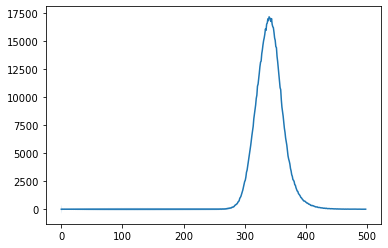

In [ ]:
plt.plot(H_lw[0])
plt.fill_between(np.arange(0,499,1),H_lw[0]-stderror,H_lw[0]+stderror,alpha=0.3)

In [ ]:
stderror

array([7.3650109 , 2.31592039, 3.24387996, 2.40460602, 2.32737993,
       2.65337905, 2.15870805, 2.16082233, 2.49109535, 2.10115791,
       2.12219766, 2.41651353, 2.08912764, 2.14009695, 2.42034936,
       2.13422979, 2.19055298, 2.45904777, 2.21050521, 2.2690507 ,
       2.53040545, 2.29997864, 2.3564123 , 2.61052848, 2.40075002,
       2.45542724, 2.69701489, 2.49642156, 2.55345815, 2.77722413,
       2.61013644, 2.65165592, 2.86811269, 2.70139219, 2.74516955,
       2.94928468, 2.78897582, 2.85005485, 3.03470721, 2.8824569 ,
       2.93610582, 3.09747358, 2.97513276, 3.03383419, 3.16258127,
       3.07081965, 3.10148642, 3.2315765 , 3.13978882, 3.18331698,
       3.28463895, 3.2169404 , 3.25121786, 3.36051056, 3.28086009,
       3.31906745, 3.40751244, 3.35237593, 3.37727825, 3.46550084,
       3.40590278, 3.43368707, 3.52570066, 3.46331914, 3.50367039,
       3.56836936, 3.5082058 , 3.53806403, 3.61617305, 3.57511034,
       3.59366857, 3.65912593, 3.60997108, 3.64268038, 3.68220

In [ ]:
 np.average(np.arange(499.5,0.5,-1), weights=stderror)

225.34554568694736

ValueError: operands could not be broadcast together with shapes (499,) (120,) 

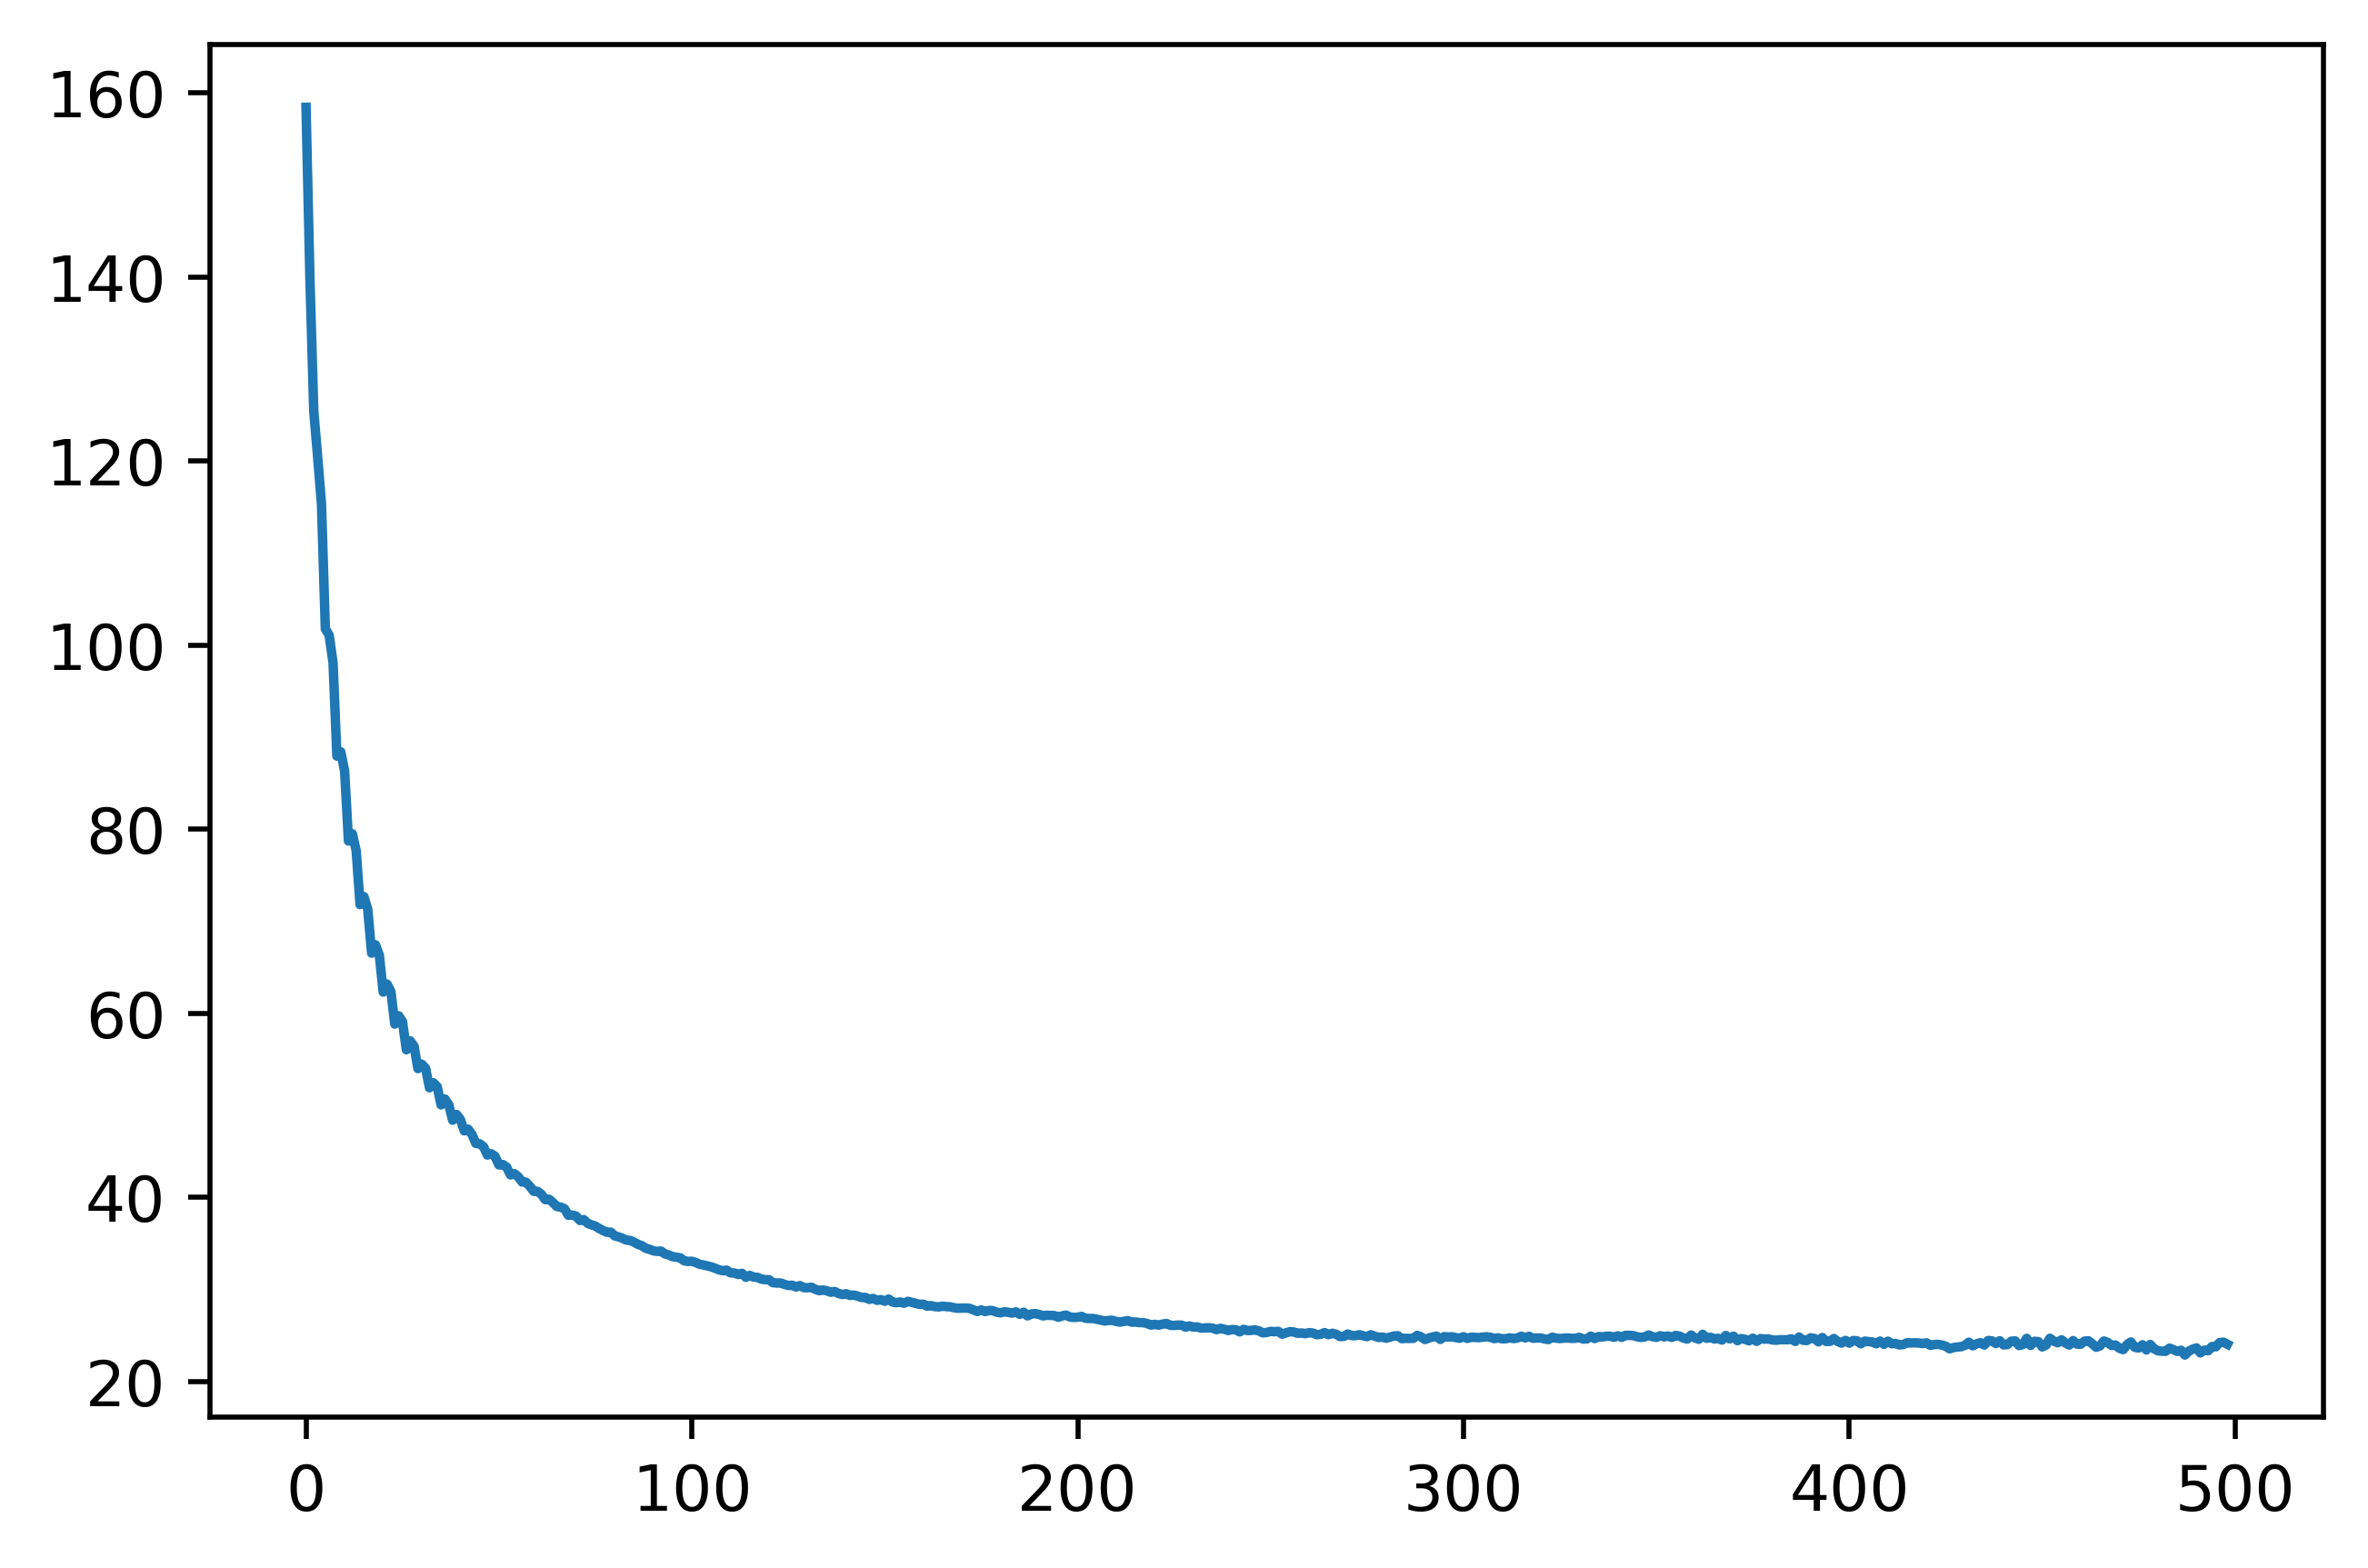

In [ ]:
plt.figure(dpi=500)
plt.plot(LW_AVERAGE_all)
plt.fill_between(np.arange(0,499,1),LW_AVERAGE_all-stderror,LW_AVERAGE_all+stderror,alpha=0.2)
plt.ylim(0,200)
plt.xlim(0,120)